# Training Networks
In this Notebook, we train networks on the HDF5 Database built. Each network takes in the noisy data, and attempts to predict the optimal circuit parameters that correspond. 

## Custom DataLoader

We need our own dataloader class to extract the correct signals/parameters. We then divide this randomly into training and test groups in a 80:20 ratio.

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
import math 
import import_ipynb
from filters import Filters, TimesteppedFilters, ButterworthFilters

# Custom Dataloader for our NN from .h5 database
class HDF5Data(Dataset):
    def __init__(self, path_to_h5, ftype):
        self.path_to_h5 = path_to_h5
        with h5py.File(path_to_h5, 'r') as f:
            signaldata = f['NoisySignals'][()]
            
            ftypeValid = False
            if ftype=='LowPass':
                ftypeValid = True
                params = f['LowPass'][()]
            elif ftype=='HighPass':
                ftypeValid = True
                params = f['HighPass'][()]
            elif ftype=='BandPass':
                ftypeValid = True
                params = f['BandPass'][()]
            elif ftype=='ButterworthLowPass':
                ftypeValid = True
                params = f['ButterworthLowPass'][()]
            
            if ftypeValid==False:
                raise ValueError("Given filter name is not one of the options")
            datalen = len(signaldata)
            
        self.signaldata = signaldata
        self.params = params
        self.datalen = datalen

    def __len__(self):
        return self.datalen

    def __getitem__(self, idx):
        return self.signaldata[idx], self.params[idx]

importing Jupyter notebook from filters.ipynb


In [3]:
# Splits full dataset into training, test, and validation sets
def loaderSplit(path_to_h5, ftype):
    dataset = HDF5Data(PATH_TO_H5, ftype)

    # Split dataset --> training:test = 80:20
    train_set_size = int(len(dataset) * 0.8)
    test_set_size = len(dataset) - train_set_size
    train_set, test_set = torch.utils.data.random_split(dataset, [train_set_size, test_set_size])

    # Split test --> test:valid = 10:10
    #test_set_size = int(len(test_set)*0.5)
    #valid_set_size = len(test_set) - test_set_size
    #valid_set, test_set = torch.utils.data.random_split(test_set, [valid_set_size, test_set_size])

    # Final Split --> training:test:valid = 80:20:0
    print("Data Points in Training Set:", len(train_set))
    print("Data Points in Test Set:",len(test_set))
    #print("Data Points in Validation Set:",len(valid_set))

    # Using PyTorch DataLoader
    test_loader = DataLoader(test_set, batch_size=100, shuffle=True)
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    #valid_loader = DataLoader(valid_set, batch_size=64, shuffle=True)
    
    return test_loader, train_loader

## Build and Train NN



In [79]:
# Decomposes electric data into frequencies and corresponding strength, adds to return single combination
def fftLayer(x):
    batchSize, datasize = x.shape
    freqArray, powSpecArray, returnArray = np.empty((batchSize, 49)), np.empty((batchSize, 49)), np.empty((batchSize, 98))
    dspan = np.linspace(0, len(x[0]), len(x[0]))
    L = np.arange(1, np.floor(len((x[0]))/2), dtype='int')
    
    # Batching passes data in groups of 100; hence, we traverse 2D array row-by-row with FFT
    for data in range(x.shape[0]):
        fhat = np.fft.fft(x[data], len(x[0]))
        powSpecArray[data] = (fhat * np.conj(fhat) / len(x[0]))[L]
        freqArray[data] = (1/np.max(dspan)*np.arange(len(x[0])))[L]
        for electricCurrent in range(0, 49): 
            returnArray[data][2*electricCurrent] = powSpecArray[data][electricCurrent]
            returnArray[data][2*electricCurrent+1] = freqArray[data][electricCurrent] #powSpecArray[data]+ freqArray[data]
   
    returnArray = torch.from_numpy(returnArray).float()
    return returnArray
        
class lowNN(nn.Module):
    def __init__(self):
        super(lowNN, self).__init__()
        self.l1 = nn.Linear(98, 32)
        self.l2 = nn.Linear(32, 32)
        self.l3 = nn.Linear(32, 16)
        self.l4 = nn.Linear(16, 5)
        self.l5 = nn.Linear(5, 3)
        self.drop = nn.Dropout(p=0.2)
        self.softmax = nn.Softmax(dim=1)
        self.LeakyReLU = nn.LeakyReLU(0.2) 
        
    def forward(self, x):
        x = func.relu(self.l1(fftLayer(x)))
        x = func.relu(self.l2(x))
        x = func.relu(self.l3(x))
        x = self.l4(x)
        x = self.l5(x)
        return x

# Works well; test set accuracy converges within 100 training epochs ~ 0.004
class highNN(nn.Module):
    def __init__(self):
        super(highNN, self).__init__()
        self.l1 = nn.Linear(98, 32)
        self.l2 = nn.Linear(32, 32)
        self.l3 = nn.Linear(32, 3)
    
    def forward(self, x):
        #print("X_forward_shape: ", x.shape)
        x = func.relu(self.l1(fftLayer(x)))
        x = func.relu(self.l2(x))
        x = func.relu(self.l3(x))
        return x

# Test set accuracy plateau ~ 0.09
class bandNN(nn.Module):
    def __init__(self):
        super(bandNN, self).__init__()
        self.l1 = nn.Linear(98, 32)
        self.l2 = nn.Linear(32, 4)
        self.l3 = nn.Linear(4, 5)
        self.l4 = nn.Linear(5, 4)
        self.l5 = nn.Linear(4, 6)
        self.drop = nn.Dropout(p=0.2)
        self.softmax = nn.Softmax(dim=1)
        self.LeakyReLU = nn.LeakyReLU(0.2) 
    
    def forward(self, x):
        x = self.LeakyReLU(self.l1(fftLayer(x)))
        x = func.relu(self.l2(x))
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        return x

class butterlowNN(nn.Module):
    def __init__(self):
        super(butterlowNN, self).__init__()
        self.l1 = nn.Linear(98, 5)
        self.l2 = nn.Linear(5, 5)
        self.l3 = nn.Linear(5, 2)
    
    def forward(self, x):
        x = func.relu(self.l1(fftLayer(x)))
        #x = self.l2(x)
        x = self.l3(x)
        return x

In [80]:
# Handles training for one epoch
def train_epoch(epoch, network, ftype, train_losses):
    network.train()
    runningloss =0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = mse_loss(output, target)
        loss.backward()
        optimizer.step()
        runningloss += float(loss)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss))#.item()   
        if batch_idx==0 and epoch==1:
            train_losses.append(loss.detach().numpy())
    train_losses.append(runningloss / batch_idx)
    torch.save(network.state_dict(), '../models/%s_model.pt' % ftype)
    torch.save(optimizer.state_dict(), '../models/%s_optimizer.pt' % ftype)
    

# Evaluate network on a test set 
def test(network, test_losses):
    network.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += mse_loss(output, target)
            #pred = output.data.max(1, keepdim=True)[1]
    test_loss /= len(test_loader)#.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}\n'.format(
    test_loss))

# Execute training loop
def train_model(network, ftype, test_losses, train_losses):
    for epoch in range(1, epochs + 1):
        test(network, test_losses)
        train_epoch(epoch, network, ftype=ftype, train_losses=train_losses)
        
def graphTraining(test_losses, train_losses, test_loader):
    test_losses = torch.Tensor(test_losses).numpy()
    train_losses = np.asarray(train_losses)
    tspan = np.linspace(0, test_losses.size, test_losses.size)
    plt.yscale('log')
    plt.plot(tspan, test_losses, label='Test Set Error')
    plt.plot(tspan, train_losses[:-1], label='Train Set Error')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

In [81]:
# Hyperparameters
epochs = 100
log_interval = 10

Data Points in Training Set: 8000
Data Points in Test Set: 2000
Using cpu device

Test set: Avg. loss: 10.4831

Train Epoch: 1 [0/8000 (0%)]	Loss: 7.556159


<ipython-input-67-15bf175f0a89>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  powSpecArray[data] = (fhat * np.conj(fhat) / len(x[0]))[L]


Train Epoch: 1 [320/8000 (4%)]	Loss: 1.639852
Train Epoch: 1 [640/8000 (8%)]	Loss: 0.940533
Train Epoch: 1 [960/8000 (12%)]	Loss: 0.793605
Train Epoch: 1 [1280/8000 (16%)]	Loss: 0.616847
Train Epoch: 1 [1600/8000 (20%)]	Loss: 1.050333
Train Epoch: 1 [1920/8000 (24%)]	Loss: 0.599845
Train Epoch: 1 [2240/8000 (28%)]	Loss: 0.533289
Train Epoch: 1 [2560/8000 (32%)]	Loss: 0.766453
Train Epoch: 1 [2880/8000 (36%)]	Loss: 0.607892
Train Epoch: 1 [3200/8000 (40%)]	Loss: 0.619109
Train Epoch: 1 [3520/8000 (44%)]	Loss: 0.809274
Train Epoch: 1 [3840/8000 (48%)]	Loss: 0.590759
Train Epoch: 1 [4160/8000 (52%)]	Loss: 1.255252
Train Epoch: 1 [4480/8000 (56%)]	Loss: 1.671984
Train Epoch: 1 [4800/8000 (60%)]	Loss: 0.599178
Train Epoch: 1 [5120/8000 (64%)]	Loss: 0.678820
Train Epoch: 1 [5440/8000 (68%)]	Loss: 0.513088
Train Epoch: 1 [5760/8000 (72%)]	Loss: 0.564964
Train Epoch: 1 [6080/8000 (76%)]	Loss: 1.237759
Train Epoch: 1 [6400/8000 (80%)]	Loss: 0.668384
Train Epoch: 1 [6720/8000 (84%)]	Loss: 0.5719

Train Epoch: 7 [6720/8000 (84%)]	Loss: 0.518765
Train Epoch: 7 [7040/8000 (88%)]	Loss: 0.556050
Train Epoch: 7 [7360/8000 (92%)]	Loss: 0.925428
Train Epoch: 7 [7680/8000 (96%)]	Loss: 0.768027

Test set: Avg. loss: 0.9699

Train Epoch: 8 [0/8000 (0%)]	Loss: 0.632627
Train Epoch: 8 [320/8000 (4%)]	Loss: 0.548963
Train Epoch: 8 [640/8000 (8%)]	Loss: 0.523225
Train Epoch: 8 [960/8000 (12%)]	Loss: 0.530358
Train Epoch: 8 [1280/8000 (16%)]	Loss: 0.520850
Train Epoch: 8 [1600/8000 (20%)]	Loss: 0.431766
Train Epoch: 8 [1920/8000 (24%)]	Loss: 0.627121
Train Epoch: 8 [2240/8000 (28%)]	Loss: 0.783943
Train Epoch: 8 [2560/8000 (32%)]	Loss: 0.642026
Train Epoch: 8 [2880/8000 (36%)]	Loss: 0.455657
Train Epoch: 8 [3200/8000 (40%)]	Loss: 1.246950
Train Epoch: 8 [3520/8000 (44%)]	Loss: 0.552516
Train Epoch: 8 [3840/8000 (48%)]	Loss: 0.392186
Train Epoch: 8 [4160/8000 (52%)]	Loss: 0.706076
Train Epoch: 8 [4480/8000 (56%)]	Loss: 0.557376
Train Epoch: 8 [4800/8000 (60%)]	Loss: 0.851593
Train Epoch: 8 [512

Train Epoch: 14 [4480/8000 (56%)]	Loss: 0.567352
Train Epoch: 14 [4800/8000 (60%)]	Loss: 0.844779
Train Epoch: 14 [5120/8000 (64%)]	Loss: 1.078690
Train Epoch: 14 [5440/8000 (68%)]	Loss: 0.408413
Train Epoch: 14 [5760/8000 (72%)]	Loss: 0.731450
Train Epoch: 14 [6080/8000 (76%)]	Loss: 1.195931
Train Epoch: 14 [6400/8000 (80%)]	Loss: 0.844886
Train Epoch: 14 [6720/8000 (84%)]	Loss: 0.810681
Train Epoch: 14 [7040/8000 (88%)]	Loss: 0.989439
Train Epoch: 14 [7360/8000 (92%)]	Loss: 1.036414
Train Epoch: 14 [7680/8000 (96%)]	Loss: 0.743964

Test set: Avg. loss: 0.7697

Train Epoch: 15 [0/8000 (0%)]	Loss: 0.985172
Train Epoch: 15 [320/8000 (4%)]	Loss: 0.757433
Train Epoch: 15 [640/8000 (8%)]	Loss: 0.842230
Train Epoch: 15 [960/8000 (12%)]	Loss: 1.038107
Train Epoch: 15 [1280/8000 (16%)]	Loss: 0.513688
Train Epoch: 15 [1600/8000 (20%)]	Loss: 0.550803
Train Epoch: 15 [1920/8000 (24%)]	Loss: 0.557118
Train Epoch: 15 [2240/8000 (28%)]	Loss: 0.441084
Train Epoch: 15 [2560/8000 (32%)]	Loss: 0.865622

Train Epoch: 21 [2240/8000 (28%)]	Loss: 0.879387
Train Epoch: 21 [2560/8000 (32%)]	Loss: 0.554816
Train Epoch: 21 [2880/8000 (36%)]	Loss: 0.855041
Train Epoch: 21 [3200/8000 (40%)]	Loss: 0.704186
Train Epoch: 21 [3520/8000 (44%)]	Loss: 0.423213
Train Epoch: 21 [3840/8000 (48%)]	Loss: 0.661012
Train Epoch: 21 [4160/8000 (52%)]	Loss: 0.545932
Train Epoch: 21 [4480/8000 (56%)]	Loss: 0.451104
Train Epoch: 21 [4800/8000 (60%)]	Loss: 0.601349
Train Epoch: 21 [5120/8000 (64%)]	Loss: 0.817234
Train Epoch: 21 [5440/8000 (68%)]	Loss: 0.531992
Train Epoch: 21 [5760/8000 (72%)]	Loss: 0.927505
Train Epoch: 21 [6080/8000 (76%)]	Loss: 0.525308
Train Epoch: 21 [6400/8000 (80%)]	Loss: 0.660227
Train Epoch: 21 [6720/8000 (84%)]	Loss: 0.748340
Train Epoch: 21 [7040/8000 (88%)]	Loss: 0.736318
Train Epoch: 21 [7360/8000 (92%)]	Loss: 0.472177
Train Epoch: 21 [7680/8000 (96%)]	Loss: 0.537361

Test set: Avg. loss: 0.8486

Train Epoch: 22 [0/8000 (0%)]	Loss: 0.462351
Train Epoch: 22 [320/8000 (4%)]	Loss: 0.688


Test set: Avg. loss: 0.8237

Train Epoch: 28 [0/8000 (0%)]	Loss: 1.090078
Train Epoch: 28 [320/8000 (4%)]	Loss: 0.323682
Train Epoch: 28 [640/8000 (8%)]	Loss: 0.495534
Train Epoch: 28 [960/8000 (12%)]	Loss: 0.324277
Train Epoch: 28 [1280/8000 (16%)]	Loss: 0.628473
Train Epoch: 28 [1600/8000 (20%)]	Loss: 0.383809
Train Epoch: 28 [1920/8000 (24%)]	Loss: 0.780835
Train Epoch: 28 [2240/8000 (28%)]	Loss: 1.075583
Train Epoch: 28 [2560/8000 (32%)]	Loss: 0.479027
Train Epoch: 28 [2880/8000 (36%)]	Loss: 0.511159
Train Epoch: 28 [3200/8000 (40%)]	Loss: 0.642224
Train Epoch: 28 [3520/8000 (44%)]	Loss: 0.384754
Train Epoch: 28 [3840/8000 (48%)]	Loss: 0.483457
Train Epoch: 28 [4160/8000 (52%)]	Loss: 0.518634
Train Epoch: 28 [4480/8000 (56%)]	Loss: 0.719211
Train Epoch: 28 [4800/8000 (60%)]	Loss: 0.529014
Train Epoch: 28 [5120/8000 (64%)]	Loss: 0.709419
Train Epoch: 28 [5440/8000 (68%)]	Loss: 0.922754
Train Epoch: 28 [5760/8000 (72%)]	Loss: 0.281871
Train Epoch: 28 [6080/8000 (76%)]	Loss: 0.552972

Train Epoch: 34 [6720/8000 (84%)]	Loss: 0.281127
Train Epoch: 34 [7040/8000 (88%)]	Loss: 0.751609
Train Epoch: 34 [7360/8000 (92%)]	Loss: 0.401539
Train Epoch: 34 [7680/8000 (96%)]	Loss: 0.733763

Test set: Avg. loss: 0.7917

Train Epoch: 35 [0/8000 (0%)]	Loss: 0.404524
Train Epoch: 35 [320/8000 (4%)]	Loss: 0.399157
Train Epoch: 35 [640/8000 (8%)]	Loss: 0.400809
Train Epoch: 35 [960/8000 (12%)]	Loss: 0.314490
Train Epoch: 35 [1280/8000 (16%)]	Loss: 0.884758
Train Epoch: 35 [1600/8000 (20%)]	Loss: 0.627913
Train Epoch: 35 [1920/8000 (24%)]	Loss: 0.451392
Train Epoch: 35 [2240/8000 (28%)]	Loss: 0.489517
Train Epoch: 35 [2560/8000 (32%)]	Loss: 0.413154
Train Epoch: 35 [2880/8000 (36%)]	Loss: 1.104574
Train Epoch: 35 [3200/8000 (40%)]	Loss: 0.930920
Train Epoch: 35 [3520/8000 (44%)]	Loss: 0.302652
Train Epoch: 35 [3840/8000 (48%)]	Loss: 0.976689
Train Epoch: 35 [4160/8000 (52%)]	Loss: 0.523869
Train Epoch: 35 [4480/8000 (56%)]	Loss: 0.592069
Train Epoch: 35 [4800/8000 (60%)]	Loss: 0.426718

Train Epoch: 41 [4480/8000 (56%)]	Loss: 0.469268
Train Epoch: 41 [4800/8000 (60%)]	Loss: 0.326372
Train Epoch: 41 [5120/8000 (64%)]	Loss: 0.567126
Train Epoch: 41 [5440/8000 (68%)]	Loss: 0.645749
Train Epoch: 41 [5760/8000 (72%)]	Loss: 0.613454
Train Epoch: 41 [6080/8000 (76%)]	Loss: 0.566219
Train Epoch: 41 [6400/8000 (80%)]	Loss: 1.182971
Train Epoch: 41 [6720/8000 (84%)]	Loss: 0.663708
Train Epoch: 41 [7040/8000 (88%)]	Loss: 0.862667
Train Epoch: 41 [7360/8000 (92%)]	Loss: 0.567282
Train Epoch: 41 [7680/8000 (96%)]	Loss: 1.103114

Test set: Avg. loss: 0.8587

Train Epoch: 42 [0/8000 (0%)]	Loss: 0.909865
Train Epoch: 42 [320/8000 (4%)]	Loss: 0.608309
Train Epoch: 42 [640/8000 (8%)]	Loss: 0.348180
Train Epoch: 42 [960/8000 (12%)]	Loss: 0.375606
Train Epoch: 42 [1280/8000 (16%)]	Loss: 0.547581
Train Epoch: 42 [1600/8000 (20%)]	Loss: 0.780499
Train Epoch: 42 [1920/8000 (24%)]	Loss: 0.639968
Train Epoch: 42 [2240/8000 (28%)]	Loss: 0.801234
Train Epoch: 42 [2560/8000 (32%)]	Loss: 0.337710

Train Epoch: 48 [2240/8000 (28%)]	Loss: 0.540596
Train Epoch: 48 [2560/8000 (32%)]	Loss: 0.545658
Train Epoch: 48 [2880/8000 (36%)]	Loss: 1.054777
Train Epoch: 48 [3200/8000 (40%)]	Loss: 0.422058
Train Epoch: 48 [3520/8000 (44%)]	Loss: 0.483786
Train Epoch: 48 [3840/8000 (48%)]	Loss: 0.570264
Train Epoch: 48 [4160/8000 (52%)]	Loss: 0.580467
Train Epoch: 48 [4480/8000 (56%)]	Loss: 0.539959
Train Epoch: 48 [4800/8000 (60%)]	Loss: 0.543991
Train Epoch: 48 [5120/8000 (64%)]	Loss: 0.656049
Train Epoch: 48 [5440/8000 (68%)]	Loss: 1.329875
Train Epoch: 48 [5760/8000 (72%)]	Loss: 0.588114
Train Epoch: 48 [6080/8000 (76%)]	Loss: 1.279688
Train Epoch: 48 [6400/8000 (80%)]	Loss: 0.720352
Train Epoch: 48 [6720/8000 (84%)]	Loss: 1.209171
Train Epoch: 48 [7040/8000 (88%)]	Loss: 0.419986
Train Epoch: 48 [7360/8000 (92%)]	Loss: 0.812285
Train Epoch: 48 [7680/8000 (96%)]	Loss: 0.662876

Test set: Avg. loss: 0.7860

Train Epoch: 49 [0/8000 (0%)]	Loss: 0.637251
Train Epoch: 49 [320/8000 (4%)]	Loss: 0.772


Test set: Avg. loss: 0.8176

Train Epoch: 55 [0/8000 (0%)]	Loss: 0.611440
Train Epoch: 55 [320/8000 (4%)]	Loss: 0.477614
Train Epoch: 55 [640/8000 (8%)]	Loss: 0.758327
Train Epoch: 55 [960/8000 (12%)]	Loss: 0.518044
Train Epoch: 55 [1280/8000 (16%)]	Loss: 0.890312
Train Epoch: 55 [1600/8000 (20%)]	Loss: 1.167297
Train Epoch: 55 [1920/8000 (24%)]	Loss: 0.473637
Train Epoch: 55 [2240/8000 (28%)]	Loss: 0.654385
Train Epoch: 55 [2560/8000 (32%)]	Loss: 1.071367
Train Epoch: 55 [2880/8000 (36%)]	Loss: 0.802144
Train Epoch: 55 [3200/8000 (40%)]	Loss: 1.119904
Train Epoch: 55 [3520/8000 (44%)]	Loss: 0.319558
Train Epoch: 55 [3840/8000 (48%)]	Loss: 0.538898
Train Epoch: 55 [4160/8000 (52%)]	Loss: 0.332306
Train Epoch: 55 [4480/8000 (56%)]	Loss: 0.478438
Train Epoch: 55 [4800/8000 (60%)]	Loss: 0.751023
Train Epoch: 55 [5120/8000 (64%)]	Loss: 0.542788
Train Epoch: 55 [5440/8000 (68%)]	Loss: 0.435723
Train Epoch: 55 [5760/8000 (72%)]	Loss: 0.686115
Train Epoch: 55 [6080/8000 (76%)]	Loss: 0.765241

Train Epoch: 61 [6720/8000 (84%)]	Loss: 0.848869
Train Epoch: 61 [7040/8000 (88%)]	Loss: 0.995170
Train Epoch: 61 [7360/8000 (92%)]	Loss: 0.358698
Train Epoch: 61 [7680/8000 (96%)]	Loss: 0.373383

Test set: Avg. loss: 0.8853

Train Epoch: 62 [0/8000 (0%)]	Loss: 0.411527
Train Epoch: 62 [320/8000 (4%)]	Loss: 0.669689
Train Epoch: 62 [640/8000 (8%)]	Loss: 0.500060
Train Epoch: 62 [960/8000 (12%)]	Loss: 0.747952
Train Epoch: 62 [1280/8000 (16%)]	Loss: 0.515289
Train Epoch: 62 [1600/8000 (20%)]	Loss: 1.260377
Train Epoch: 62 [1920/8000 (24%)]	Loss: 0.586225
Train Epoch: 62 [2240/8000 (28%)]	Loss: 0.426470
Train Epoch: 62 [2560/8000 (32%)]	Loss: 0.646813
Train Epoch: 62 [2880/8000 (36%)]	Loss: 0.464422
Train Epoch: 62 [3200/8000 (40%)]	Loss: 0.844822
Train Epoch: 62 [3520/8000 (44%)]	Loss: 0.372475
Train Epoch: 62 [3840/8000 (48%)]	Loss: 0.367202
Train Epoch: 62 [4160/8000 (52%)]	Loss: 0.470441
Train Epoch: 62 [4480/8000 (56%)]	Loss: 0.393377
Train Epoch: 62 [4800/8000 (60%)]	Loss: 0.721713

Train Epoch: 68 [4480/8000 (56%)]	Loss: 0.377578
Train Epoch: 68 [4800/8000 (60%)]	Loss: 0.398870
Train Epoch: 68 [5120/8000 (64%)]	Loss: 0.597023
Train Epoch: 68 [5440/8000 (68%)]	Loss: 0.390855
Train Epoch: 68 [5760/8000 (72%)]	Loss: 0.415782
Train Epoch: 68 [6080/8000 (76%)]	Loss: 0.983828
Train Epoch: 68 [6400/8000 (80%)]	Loss: 0.469610
Train Epoch: 68 [6720/8000 (84%)]	Loss: 0.477794
Train Epoch: 68 [7040/8000 (88%)]	Loss: 0.440212
Train Epoch: 68 [7360/8000 (92%)]	Loss: 0.447941
Train Epoch: 68 [7680/8000 (96%)]	Loss: 0.494200

Test set: Avg. loss: 0.9436

Train Epoch: 69 [0/8000 (0%)]	Loss: 0.770229
Train Epoch: 69 [320/8000 (4%)]	Loss: 0.495890
Train Epoch: 69 [640/8000 (8%)]	Loss: 0.457758
Train Epoch: 69 [960/8000 (12%)]	Loss: 2.880238
Train Epoch: 69 [1280/8000 (16%)]	Loss: 0.487668
Train Epoch: 69 [1600/8000 (20%)]	Loss: 0.878751
Train Epoch: 69 [1920/8000 (24%)]	Loss: 0.231860
Train Epoch: 69 [2240/8000 (28%)]	Loss: 0.501312
Train Epoch: 69 [2560/8000 (32%)]	Loss: 0.538629

Train Epoch: 75 [2240/8000 (28%)]	Loss: 0.656709
Train Epoch: 75 [2560/8000 (32%)]	Loss: 0.289397
Train Epoch: 75 [2880/8000 (36%)]	Loss: 0.221851
Train Epoch: 75 [3200/8000 (40%)]	Loss: 0.519563
Train Epoch: 75 [3520/8000 (44%)]	Loss: 0.448195
Train Epoch: 75 [3840/8000 (48%)]	Loss: 0.587395
Train Epoch: 75 [4160/8000 (52%)]	Loss: 0.555291
Train Epoch: 75 [4480/8000 (56%)]	Loss: 0.601285
Train Epoch: 75 [4800/8000 (60%)]	Loss: 0.552512
Train Epoch: 75 [5120/8000 (64%)]	Loss: 0.292555
Train Epoch: 75 [5440/8000 (68%)]	Loss: 0.596542
Train Epoch: 75 [5760/8000 (72%)]	Loss: 0.302175
Train Epoch: 75 [6080/8000 (76%)]	Loss: 0.612432
Train Epoch: 75 [6400/8000 (80%)]	Loss: 0.318970
Train Epoch: 75 [6720/8000 (84%)]	Loss: 0.796639
Train Epoch: 75 [7040/8000 (88%)]	Loss: 0.412442
Train Epoch: 75 [7360/8000 (92%)]	Loss: 0.640493
Train Epoch: 75 [7680/8000 (96%)]	Loss: 0.549704

Test set: Avg. loss: 0.8292

Train Epoch: 76 [0/8000 (0%)]	Loss: 0.372131
Train Epoch: 76 [320/8000 (4%)]	Loss: 0.523


Test set: Avg. loss: 0.8776

Train Epoch: 82 [0/8000 (0%)]	Loss: 0.566574
Train Epoch: 82 [320/8000 (4%)]	Loss: 0.525944
Train Epoch: 82 [640/8000 (8%)]	Loss: 0.483383
Train Epoch: 82 [960/8000 (12%)]	Loss: 0.469653
Train Epoch: 82 [1280/8000 (16%)]	Loss: 0.244370
Train Epoch: 82 [1600/8000 (20%)]	Loss: 0.811490
Train Epoch: 82 [1920/8000 (24%)]	Loss: 0.423824
Train Epoch: 82 [2240/8000 (28%)]	Loss: 0.320968
Train Epoch: 82 [2560/8000 (32%)]	Loss: 0.434632
Train Epoch: 82 [2880/8000 (36%)]	Loss: 0.379096
Train Epoch: 82 [3200/8000 (40%)]	Loss: 1.400264
Train Epoch: 82 [3520/8000 (44%)]	Loss: 0.618244
Train Epoch: 82 [3840/8000 (48%)]	Loss: 0.740917
Train Epoch: 82 [4160/8000 (52%)]	Loss: 0.754288
Train Epoch: 82 [4480/8000 (56%)]	Loss: 0.323817
Train Epoch: 82 [4800/8000 (60%)]	Loss: 0.433842
Train Epoch: 82 [5120/8000 (64%)]	Loss: 0.660711
Train Epoch: 82 [5440/8000 (68%)]	Loss: 0.450573
Train Epoch: 82 [5760/8000 (72%)]	Loss: 0.277258
Train Epoch: 82 [6080/8000 (76%)]	Loss: 0.526432

Train Epoch: 88 [6720/8000 (84%)]	Loss: 0.317856
Train Epoch: 88 [7040/8000 (88%)]	Loss: 0.510438
Train Epoch: 88 [7360/8000 (92%)]	Loss: 0.414378
Train Epoch: 88 [7680/8000 (96%)]	Loss: 0.736311

Test set: Avg. loss: 0.8907

Train Epoch: 89 [0/8000 (0%)]	Loss: 0.522479
Train Epoch: 89 [320/8000 (4%)]	Loss: 0.571931
Train Epoch: 89 [640/8000 (8%)]	Loss: 0.528509
Train Epoch: 89 [960/8000 (12%)]	Loss: 0.360246
Train Epoch: 89 [1280/8000 (16%)]	Loss: 0.431482
Train Epoch: 89 [1600/8000 (20%)]	Loss: 0.430221
Train Epoch: 89 [1920/8000 (24%)]	Loss: 0.399921
Train Epoch: 89 [2240/8000 (28%)]	Loss: 0.737021
Train Epoch: 89 [2560/8000 (32%)]	Loss: 0.592096
Train Epoch: 89 [2880/8000 (36%)]	Loss: 1.130975
Train Epoch: 89 [3200/8000 (40%)]	Loss: 0.433322
Train Epoch: 89 [3520/8000 (44%)]	Loss: 0.541396
Train Epoch: 89 [3840/8000 (48%)]	Loss: 0.573313
Train Epoch: 89 [4160/8000 (52%)]	Loss: 0.295227
Train Epoch: 89 [4480/8000 (56%)]	Loss: 0.463883
Train Epoch: 89 [4800/8000 (60%)]	Loss: 0.519271

Train Epoch: 95 [4480/8000 (56%)]	Loss: 0.420177
Train Epoch: 95 [4800/8000 (60%)]	Loss: 0.190547
Train Epoch: 95 [5120/8000 (64%)]	Loss: 0.392569
Train Epoch: 95 [5440/8000 (68%)]	Loss: 0.573873
Train Epoch: 95 [5760/8000 (72%)]	Loss: 0.174204
Train Epoch: 95 [6080/8000 (76%)]	Loss: 0.465622
Train Epoch: 95 [6400/8000 (80%)]	Loss: 0.609999
Train Epoch: 95 [6720/8000 (84%)]	Loss: 0.486505
Train Epoch: 95 [7040/8000 (88%)]	Loss: 0.662069
Train Epoch: 95 [7360/8000 (92%)]	Loss: 0.508972
Train Epoch: 95 [7680/8000 (96%)]	Loss: 0.669565

Test set: Avg. loss: 0.9461

Train Epoch: 96 [0/8000 (0%)]	Loss: 0.428711
Train Epoch: 96 [320/8000 (4%)]	Loss: 0.597883
Train Epoch: 96 [640/8000 (8%)]	Loss: 0.413850
Train Epoch: 96 [960/8000 (12%)]	Loss: 0.500226
Train Epoch: 96 [1280/8000 (16%)]	Loss: 0.828463
Train Epoch: 96 [1600/8000 (20%)]	Loss: 0.386024
Train Epoch: 96 [1920/8000 (24%)]	Loss: 0.357860
Train Epoch: 96 [2240/8000 (28%)]	Loss: 0.363086
Train Epoch: 96 [2560/8000 (32%)]	Loss: 0.286282

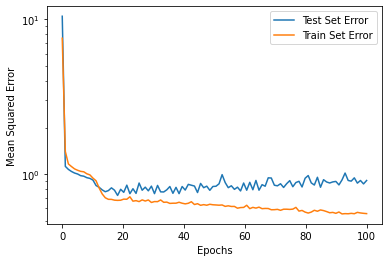

In [70]:
# Build and train LowPass model 
if __name__=='__main__': 
    PATH_TO_H5 = '/Users/aaronphilip/ScienceFair/projects/NanoporeSequencingFiltering/database/RefinedNanoporeFiltering.h5'
    ftype = 'LowPass'
    test_loader, train_loader = loaderSplit(PATH_TO_H5, ftype)
    
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]


    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")

    # 100 long input vector --> 2 long output vector 
    lowModel = lowNN().to(device)
    
    # Optimizer and Loss Function
    learning_rate=1e-3
    optimizer = optim.Adam(lowModel.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()

    # Training
    train_model(lowModel, ftype=ftype, test_losses=test_losses, train_losses=train_losses)
    
    # Graph MSE vs. Error
    graphTraining(test_losses, train_losses, test_loader)

Data Points in Training Set: 8000
Data Points in Test Set: 2000
Using cpu device

Test set: Avg. loss: 1551.8439

Train Epoch: 1 [0/8000 (0%)]	Loss: 1480.263306
Train Epoch: 1 [320/8000 (4%)]	Loss: 560.173035
Train Epoch: 1 [640/8000 (8%)]	Loss: 338.796204
Train Epoch: 1 [960/8000 (12%)]	Loss: 285.103302
Train Epoch: 1 [1280/8000 (16%)]	Loss: 443.595734
Train Epoch: 1 [1600/8000 (20%)]	Loss: 497.577545


<ipython-input-30-212a67d4d72e>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  powSpecArray[data] = (fhat * np.conj(fhat) / len(x[0]))[L]


Train Epoch: 1 [1920/8000 (24%)]	Loss: 452.415375
Train Epoch: 1 [2240/8000 (28%)]	Loss: 392.540375
Train Epoch: 1 [2560/8000 (32%)]	Loss: 330.907867
Train Epoch: 1 [2880/8000 (36%)]	Loss: 471.367157
Train Epoch: 1 [3200/8000 (40%)]	Loss: 416.180267
Train Epoch: 1 [3520/8000 (44%)]	Loss: 433.513794
Train Epoch: 1 [3840/8000 (48%)]	Loss: 357.020844
Train Epoch: 1 [4160/8000 (52%)]	Loss: 418.642334
Train Epoch: 1 [4480/8000 (56%)]	Loss: 469.949188
Train Epoch: 1 [4800/8000 (60%)]	Loss: 457.196747
Train Epoch: 1 [5120/8000 (64%)]	Loss: 330.514923
Train Epoch: 1 [5440/8000 (68%)]	Loss: 358.570068
Train Epoch: 1 [5760/8000 (72%)]	Loss: 416.213531
Train Epoch: 1 [6080/8000 (76%)]	Loss: 443.493927
Train Epoch: 1 [6400/8000 (80%)]	Loss: 392.644531
Train Epoch: 1 [6720/8000 (84%)]	Loss: 359.805267
Train Epoch: 1 [7040/8000 (88%)]	Loss: 400.483154
Train Epoch: 1 [7360/8000 (92%)]	Loss: 325.140808
Train Epoch: 1 [7680/8000 (96%)]	Loss: 352.088379

Test set: Avg. loss: 384.0349

Train Epoch: 2 [0/

Train Epoch: 7 [7680/8000 (96%)]	Loss: 10.087152

Test set: Avg. loss: 13.6371

Train Epoch: 8 [0/8000 (0%)]	Loss: 11.231694
Train Epoch: 8 [320/8000 (4%)]	Loss: 10.027329
Train Epoch: 8 [640/8000 (8%)]	Loss: 12.447430
Train Epoch: 8 [960/8000 (12%)]	Loss: 8.302487
Train Epoch: 8 [1280/8000 (16%)]	Loss: 9.438095
Train Epoch: 8 [1600/8000 (20%)]	Loss: 11.014121
Train Epoch: 8 [1920/8000 (24%)]	Loss: 8.062356
Train Epoch: 8 [2240/8000 (28%)]	Loss: 12.694276
Train Epoch: 8 [2560/8000 (32%)]	Loss: 7.833754
Train Epoch: 8 [2880/8000 (36%)]	Loss: 12.008842
Train Epoch: 8 [3200/8000 (40%)]	Loss: 8.652521
Train Epoch: 8 [3520/8000 (44%)]	Loss: 10.641311
Train Epoch: 8 [3840/8000 (48%)]	Loss: 9.016409
Train Epoch: 8 [4160/8000 (52%)]	Loss: 9.753239
Train Epoch: 8 [4480/8000 (56%)]	Loss: 19.689524
Train Epoch: 8 [4800/8000 (60%)]	Loss: 10.337075
Train Epoch: 8 [5120/8000 (64%)]	Loss: 9.848771
Train Epoch: 8 [5440/8000 (68%)]	Loss: 18.976332
Train Epoch: 8 [5760/8000 (72%)]	Loss: 21.685968
Train 

Train Epoch: 14 [7680/8000 (96%)]	Loss: 14.509876

Test set: Avg. loss: 8.9646

Train Epoch: 15 [0/8000 (0%)]	Loss: 7.337369
Train Epoch: 15 [320/8000 (4%)]	Loss: 9.583150
Train Epoch: 15 [640/8000 (8%)]	Loss: 9.761800
Train Epoch: 15 [960/8000 (12%)]	Loss: 12.528623
Train Epoch: 15 [1280/8000 (16%)]	Loss: 10.867970
Train Epoch: 15 [1600/8000 (20%)]	Loss: 14.046314
Train Epoch: 15 [1920/8000 (24%)]	Loss: 16.983625
Train Epoch: 15 [2240/8000 (28%)]	Loss: 13.990021
Train Epoch: 15 [2560/8000 (32%)]	Loss: 12.850923
Train Epoch: 15 [2880/8000 (36%)]	Loss: 8.294473
Train Epoch: 15 [3200/8000 (40%)]	Loss: 12.628559
Train Epoch: 15 [3520/8000 (44%)]	Loss: 6.525544
Train Epoch: 15 [3840/8000 (48%)]	Loss: 9.221894
Train Epoch: 15 [4160/8000 (52%)]	Loss: 9.282039
Train Epoch: 15 [4480/8000 (56%)]	Loss: 22.655985
Train Epoch: 15 [4800/8000 (60%)]	Loss: 11.000728
Train Epoch: 15 [5120/8000 (64%)]	Loss: 16.279892
Train Epoch: 15 [5440/8000 (68%)]	Loss: 14.845822
Train Epoch: 15 [5760/8000 (72%)]	Lo

Train Epoch: 21 [5440/8000 (68%)]	Loss: 10.996544
Train Epoch: 21 [5760/8000 (72%)]	Loss: 17.999838
Train Epoch: 21 [6080/8000 (76%)]	Loss: 8.532968
Train Epoch: 21 [6400/8000 (80%)]	Loss: 9.739142
Train Epoch: 21 [6720/8000 (84%)]	Loss: 13.124171
Train Epoch: 21 [7040/8000 (88%)]	Loss: 12.465027
Train Epoch: 21 [7360/8000 (92%)]	Loss: 17.423241
Train Epoch: 21 [7680/8000 (96%)]	Loss: 10.152172

Test set: Avg. loss: 11.4002

Train Epoch: 22 [0/8000 (0%)]	Loss: 11.566661
Train Epoch: 22 [320/8000 (4%)]	Loss: 13.818657
Train Epoch: 22 [640/8000 (8%)]	Loss: 9.279923
Train Epoch: 22 [960/8000 (12%)]	Loss: 11.895654
Train Epoch: 22 [1280/8000 (16%)]	Loss: 11.592196
Train Epoch: 22 [1600/8000 (20%)]	Loss: 12.328681
Train Epoch: 22 [1920/8000 (24%)]	Loss: 13.125186
Train Epoch: 22 [2240/8000 (28%)]	Loss: 9.188191
Train Epoch: 22 [2560/8000 (32%)]	Loss: 9.197643
Train Epoch: 22 [2880/8000 (36%)]	Loss: 10.123173
Train Epoch: 22 [3200/8000 (40%)]	Loss: 13.595742
Train Epoch: 22 [3520/8000 (44%)]

Train Epoch: 28 [3520/8000 (44%)]	Loss: 12.002849
Train Epoch: 28 [3840/8000 (48%)]	Loss: 10.823673
Train Epoch: 28 [4160/8000 (52%)]	Loss: 6.094017
Train Epoch: 28 [4480/8000 (56%)]	Loss: 8.362979
Train Epoch: 28 [4800/8000 (60%)]	Loss: 11.919362
Train Epoch: 28 [5120/8000 (64%)]	Loss: 10.111822
Train Epoch: 28 [5440/8000 (68%)]	Loss: 11.996437
Train Epoch: 28 [5760/8000 (72%)]	Loss: 8.709357
Train Epoch: 28 [6080/8000 (76%)]	Loss: 8.537724
Train Epoch: 28 [6400/8000 (80%)]	Loss: 8.978742
Train Epoch: 28 [6720/8000 (84%)]	Loss: 10.672889
Train Epoch: 28 [7040/8000 (88%)]	Loss: 11.662292
Train Epoch: 28 [7360/8000 (92%)]	Loss: 20.540421
Train Epoch: 28 [7680/8000 (96%)]	Loss: 9.997645

Test set: Avg. loss: 8.3944

Train Epoch: 29 [0/8000 (0%)]	Loss: 7.649647
Train Epoch: 29 [320/8000 (4%)]	Loss: 7.951257
Train Epoch: 29 [640/8000 (8%)]	Loss: 7.858481
Train Epoch: 29 [960/8000 (12%)]	Loss: 8.031092
Train Epoch: 29 [1280/8000 (16%)]	Loss: 9.927501
Train Epoch: 29 [1600/8000 (20%)]	Loss: 

Train Epoch: 35 [1920/8000 (24%)]	Loss: 10.121851
Train Epoch: 35 [2240/8000 (28%)]	Loss: 19.123232
Train Epoch: 35 [2560/8000 (32%)]	Loss: 8.676696
Train Epoch: 35 [2880/8000 (36%)]	Loss: 14.335521
Train Epoch: 35 [3200/8000 (40%)]	Loss: 9.284917
Train Epoch: 35 [3520/8000 (44%)]	Loss: 9.111464
Train Epoch: 35 [3840/8000 (48%)]	Loss: 11.131630
Train Epoch: 35 [4160/8000 (52%)]	Loss: 8.564824
Train Epoch: 35 [4480/8000 (56%)]	Loss: 9.035596
Train Epoch: 35 [4800/8000 (60%)]	Loss: 7.576716
Train Epoch: 35 [5120/8000 (64%)]	Loss: 8.998147
Train Epoch: 35 [5440/8000 (68%)]	Loss: 22.948572
Train Epoch: 35 [5760/8000 (72%)]	Loss: 7.696981
Train Epoch: 35 [6080/8000 (76%)]	Loss: 9.742679
Train Epoch: 35 [6400/8000 (80%)]	Loss: 11.468464
Train Epoch: 35 [6720/8000 (84%)]	Loss: 8.336871
Train Epoch: 35 [7040/8000 (88%)]	Loss: 8.051526
Train Epoch: 35 [7360/8000 (92%)]	Loss: 14.065553
Train Epoch: 35 [7680/8000 (96%)]	Loss: 11.274907

Test set: Avg. loss: 10.4742

Train Epoch: 36 [0/8000 (0%)]	

Train Epoch: 41 [7040/8000 (88%)]	Loss: 10.966718
Train Epoch: 41 [7360/8000 (92%)]	Loss: 11.051513
Train Epoch: 41 [7680/8000 (96%)]	Loss: 10.262593

Test set: Avg. loss: 9.3030

Train Epoch: 42 [0/8000 (0%)]	Loss: 10.707395
Train Epoch: 42 [320/8000 (4%)]	Loss: 11.683674
Train Epoch: 42 [640/8000 (8%)]	Loss: 6.987290
Train Epoch: 42 [960/8000 (12%)]	Loss: 11.438277
Train Epoch: 42 [1280/8000 (16%)]	Loss: 9.433665
Train Epoch: 42 [1600/8000 (20%)]	Loss: 12.821506
Train Epoch: 42 [1920/8000 (24%)]	Loss: 14.173945
Train Epoch: 42 [2240/8000 (28%)]	Loss: 19.280651
Train Epoch: 42 [2560/8000 (32%)]	Loss: 11.011299
Train Epoch: 42 [2880/8000 (36%)]	Loss: 7.917340
Train Epoch: 42 [3200/8000 (40%)]	Loss: 19.052177
Train Epoch: 42 [3520/8000 (44%)]	Loss: 6.508293
Train Epoch: 42 [3840/8000 (48%)]	Loss: 8.084024
Train Epoch: 42 [4160/8000 (52%)]	Loss: 8.727523
Train Epoch: 42 [4480/8000 (56%)]	Loss: 11.541950
Train Epoch: 42 [4800/8000 (60%)]	Loss: 8.477086
Train Epoch: 42 [5120/8000 (64%)]	Lo

Train Epoch: 48 [5760/8000 (72%)]	Loss: 5.748438
Train Epoch: 48 [6080/8000 (76%)]	Loss: 7.712788
Train Epoch: 48 [6400/8000 (80%)]	Loss: 8.095722
Train Epoch: 48 [6720/8000 (84%)]	Loss: 10.214936
Train Epoch: 48 [7040/8000 (88%)]	Loss: 7.457251
Train Epoch: 48 [7360/8000 (92%)]	Loss: 9.754443
Train Epoch: 48 [7680/8000 (96%)]	Loss: 19.801586

Test set: Avg. loss: 20.8020

Train Epoch: 49 [0/8000 (0%)]	Loss: 17.938284
Train Epoch: 49 [320/8000 (4%)]	Loss: 10.556804
Train Epoch: 49 [640/8000 (8%)]	Loss: 7.020527
Train Epoch: 49 [960/8000 (12%)]	Loss: 8.221347
Train Epoch: 49 [1280/8000 (16%)]	Loss: 8.371388
Train Epoch: 49 [1600/8000 (20%)]	Loss: 11.875844
Train Epoch: 49 [1920/8000 (24%)]	Loss: 10.289996
Train Epoch: 49 [2240/8000 (28%)]	Loss: 9.542193
Train Epoch: 49 [2560/8000 (32%)]	Loss: 10.609101
Train Epoch: 49 [2880/8000 (36%)]	Loss: 6.947607
Train Epoch: 49 [3200/8000 (40%)]	Loss: 8.144300
Train Epoch: 49 [3520/8000 (44%)]	Loss: 8.960906
Train Epoch: 49 [3840/8000 (48%)]	Loss: 

Train Epoch: 55 [1920/8000 (24%)]	Loss: 10.239846
Train Epoch: 55 [2240/8000 (28%)]	Loss: 8.625323
Train Epoch: 55 [2560/8000 (32%)]	Loss: 11.380773
Train Epoch: 55 [2880/8000 (36%)]	Loss: 9.900401
Train Epoch: 55 [3200/8000 (40%)]	Loss: 10.150218
Train Epoch: 55 [3520/8000 (44%)]	Loss: 19.095327
Train Epoch: 55 [3840/8000 (48%)]	Loss: 12.034187
Train Epoch: 55 [4160/8000 (52%)]	Loss: 7.443934
Train Epoch: 55 [4480/8000 (56%)]	Loss: 8.306710
Train Epoch: 55 [4800/8000 (60%)]	Loss: 9.204162
Train Epoch: 55 [5120/8000 (64%)]	Loss: 7.184279
Train Epoch: 55 [5440/8000 (68%)]	Loss: 6.892381
Train Epoch: 55 [5760/8000 (72%)]	Loss: 18.665968
Train Epoch: 55 [6080/8000 (76%)]	Loss: 11.586689
Train Epoch: 55 [6400/8000 (80%)]	Loss: 8.871188
Train Epoch: 55 [6720/8000 (84%)]	Loss: 17.771706
Train Epoch: 55 [7040/8000 (88%)]	Loss: 11.307366
Train Epoch: 55 [7360/8000 (92%)]	Loss: 11.592628
Train Epoch: 55 [7680/8000 (96%)]	Loss: 8.121031

Test set: Avg. loss: 8.3473

Train Epoch: 56 [0/8000 (0%)]


Test set: Avg. loss: 10.9911

Train Epoch: 62 [0/8000 (0%)]	Loss: 14.605439
Train Epoch: 62 [320/8000 (4%)]	Loss: 11.531238
Train Epoch: 62 [640/8000 (8%)]	Loss: 8.008659
Train Epoch: 62 [960/8000 (12%)]	Loss: 11.455220
Train Epoch: 62 [1280/8000 (16%)]	Loss: 16.023081
Train Epoch: 62 [1600/8000 (20%)]	Loss: 10.522971
Train Epoch: 62 [1920/8000 (24%)]	Loss: 15.776031
Train Epoch: 62 [2240/8000 (28%)]	Loss: 12.303162
Train Epoch: 62 [2560/8000 (32%)]	Loss: 11.000600
Train Epoch: 62 [2880/8000 (36%)]	Loss: 25.762421
Train Epoch: 62 [3200/8000 (40%)]	Loss: 12.549995
Train Epoch: 62 [3520/8000 (44%)]	Loss: 21.461325
Train Epoch: 62 [3840/8000 (48%)]	Loss: 12.581864
Train Epoch: 62 [4160/8000 (52%)]	Loss: 15.714149
Train Epoch: 62 [4480/8000 (56%)]	Loss: 6.910554
Train Epoch: 62 [4800/8000 (60%)]	Loss: 10.979695
Train Epoch: 62 [5120/8000 (64%)]	Loss: 16.888964
Train Epoch: 62 [5440/8000 (68%)]	Loss: 12.086258
Train Epoch: 62 [5760/8000 (72%)]	Loss: 13.563436
Train Epoch: 62 [6080/8000 (76

Train Epoch: 68 [7680/8000 (96%)]	Loss: 12.551799

Test set: Avg. loss: 11.6769

Train Epoch: 69 [0/8000 (0%)]	Loss: 10.169015
Train Epoch: 69 [320/8000 (4%)]	Loss: 8.087367
Train Epoch: 69 [640/8000 (8%)]	Loss: 13.092830
Train Epoch: 69 [960/8000 (12%)]	Loss: 22.869452
Train Epoch: 69 [1280/8000 (16%)]	Loss: 9.422711
Train Epoch: 69 [1600/8000 (20%)]	Loss: 9.849305
Train Epoch: 69 [1920/8000 (24%)]	Loss: 10.663745
Train Epoch: 69 [2240/8000 (28%)]	Loss: 25.889296
Train Epoch: 69 [2560/8000 (32%)]	Loss: 9.758883
Train Epoch: 69 [2880/8000 (36%)]	Loss: 9.066408
Train Epoch: 69 [3200/8000 (40%)]	Loss: 8.917624
Train Epoch: 69 [3520/8000 (44%)]	Loss: 7.346112
Train Epoch: 69 [3840/8000 (48%)]	Loss: 7.818523
Train Epoch: 69 [4160/8000 (52%)]	Loss: 9.320778
Train Epoch: 69 [4480/8000 (56%)]	Loss: 6.919046
Train Epoch: 69 [4800/8000 (60%)]	Loss: 8.511791
Train Epoch: 69 [5120/8000 (64%)]	Loss: 7.261006
Train Epoch: 69 [5440/8000 (68%)]	Loss: 7.828520
Train Epoch: 69 [5760/8000 (72%)]	Loss: 9

Train Epoch: 75 [3840/8000 (48%)]	Loss: 9.478745
Train Epoch: 75 [4160/8000 (52%)]	Loss: 12.450341
Train Epoch: 75 [4480/8000 (56%)]	Loss: 7.460964
Train Epoch: 75 [4800/8000 (60%)]	Loss: 8.526191
Train Epoch: 75 [5120/8000 (64%)]	Loss: 20.734863
Train Epoch: 75 [5440/8000 (68%)]	Loss: 18.680410
Train Epoch: 75 [5760/8000 (72%)]	Loss: 12.399432
Train Epoch: 75 [6080/8000 (76%)]	Loss: 15.736504
Train Epoch: 75 [6400/8000 (80%)]	Loss: 13.230011
Train Epoch: 75 [6720/8000 (84%)]	Loss: 6.781605
Train Epoch: 75 [7040/8000 (88%)]	Loss: 7.825265
Train Epoch: 75 [7360/8000 (92%)]	Loss: 12.143350
Train Epoch: 75 [7680/8000 (96%)]	Loss: 8.178864

Test set: Avg. loss: 16.3836

Train Epoch: 76 [0/8000 (0%)]	Loss: 12.142938
Train Epoch: 76 [320/8000 (4%)]	Loss: 14.108054
Train Epoch: 76 [640/8000 (8%)]	Loss: 12.444717
Train Epoch: 76 [960/8000 (12%)]	Loss: 13.188817
Train Epoch: 76 [1280/8000 (16%)]	Loss: 13.724568
Train Epoch: 76 [1600/8000 (20%)]	Loss: 9.934986
Train Epoch: 76 [1920/8000 (24%)]	L

Train Epoch: 82 [3520/8000 (44%)]	Loss: 8.469418
Train Epoch: 82 [3840/8000 (48%)]	Loss: 9.938315
Train Epoch: 82 [4160/8000 (52%)]	Loss: 10.423219
Train Epoch: 82 [4480/8000 (56%)]	Loss: 9.653000
Train Epoch: 82 [4800/8000 (60%)]	Loss: 12.403964
Train Epoch: 82 [5120/8000 (64%)]	Loss: 7.910512
Train Epoch: 82 [5440/8000 (68%)]	Loss: 24.143173
Train Epoch: 82 [5760/8000 (72%)]	Loss: 9.888700
Train Epoch: 82 [6080/8000 (76%)]	Loss: 11.150539
Train Epoch: 82 [6400/8000 (80%)]	Loss: 6.942015
Train Epoch: 82 [6720/8000 (84%)]	Loss: 14.533559
Train Epoch: 82 [7040/8000 (88%)]	Loss: 10.325552
Train Epoch: 82 [7360/8000 (92%)]	Loss: 8.110225
Train Epoch: 82 [7680/8000 (96%)]	Loss: 14.036401

Test set: Avg. loss: 8.7190

Train Epoch: 83 [0/8000 (0%)]	Loss: 8.288654
Train Epoch: 83 [320/8000 (4%)]	Loss: 8.011756
Train Epoch: 83 [640/8000 (8%)]	Loss: 8.616236
Train Epoch: 83 [960/8000 (12%)]	Loss: 9.241420
Train Epoch: 83 [1280/8000 (16%)]	Loss: 8.460506
Train Epoch: 83 [1600/8000 (20%)]	Loss: 7

Train Epoch: 89 [1920/8000 (24%)]	Loss: 9.418128
Train Epoch: 89 [2240/8000 (28%)]	Loss: 8.197625
Train Epoch: 89 [2560/8000 (32%)]	Loss: 7.649859
Train Epoch: 89 [2880/8000 (36%)]	Loss: 10.787715
Train Epoch: 89 [3200/8000 (40%)]	Loss: 10.520581
Train Epoch: 89 [3520/8000 (44%)]	Loss: 8.090925
Train Epoch: 89 [3840/8000 (48%)]	Loss: 8.322580
Train Epoch: 89 [4160/8000 (52%)]	Loss: 5.848179
Train Epoch: 89 [4480/8000 (56%)]	Loss: 9.912331
Train Epoch: 89 [4800/8000 (60%)]	Loss: 10.662057
Train Epoch: 89 [5120/8000 (64%)]	Loss: 12.015465
Train Epoch: 89 [5440/8000 (68%)]	Loss: 8.386263
Train Epoch: 89 [5760/8000 (72%)]	Loss: 9.045965
Train Epoch: 89 [6080/8000 (76%)]	Loss: 10.571088
Train Epoch: 89 [6400/8000 (80%)]	Loss: 8.870998
Train Epoch: 89 [6720/8000 (84%)]	Loss: 8.127318
Train Epoch: 89 [7040/8000 (88%)]	Loss: 11.251079
Train Epoch: 89 [7360/8000 (92%)]	Loss: 9.622758
Train Epoch: 89 [7680/8000 (96%)]	Loss: 7.528581

Test set: Avg. loss: 8.7540

Train Epoch: 90 [0/8000 (0%)]	Los

Train Epoch: 95 [7040/8000 (88%)]	Loss: 9.104289
Train Epoch: 95 [7360/8000 (92%)]	Loss: 6.711343
Train Epoch: 95 [7680/8000 (96%)]	Loss: 8.464444

Test set: Avg. loss: 8.0502

Train Epoch: 96 [0/8000 (0%)]	Loss: 6.659362
Train Epoch: 96 [320/8000 (4%)]	Loss: 8.660171
Train Epoch: 96 [640/8000 (8%)]	Loss: 8.280570
Train Epoch: 96 [960/8000 (12%)]	Loss: 7.661690
Train Epoch: 96 [1280/8000 (16%)]	Loss: 8.852593
Train Epoch: 96 [1600/8000 (20%)]	Loss: 9.030130
Train Epoch: 96 [1920/8000 (24%)]	Loss: 10.845950
Train Epoch: 96 [2240/8000 (28%)]	Loss: 8.412644
Train Epoch: 96 [2560/8000 (32%)]	Loss: 9.261808
Train Epoch: 96 [2880/8000 (36%)]	Loss: 8.144542
Train Epoch: 96 [3200/8000 (40%)]	Loss: 8.611929
Train Epoch: 96 [3520/8000 (44%)]	Loss: 6.603890
Train Epoch: 96 [3840/8000 (48%)]	Loss: 9.291144
Train Epoch: 96 [4160/8000 (52%)]	Loss: 8.536763
Train Epoch: 96 [4480/8000 (56%)]	Loss: 8.969863
Train Epoch: 96 [4800/8000 (60%)]	Loss: 8.991959
Train Epoch: 96 [5120/8000 (64%)]	Loss: 7.24472

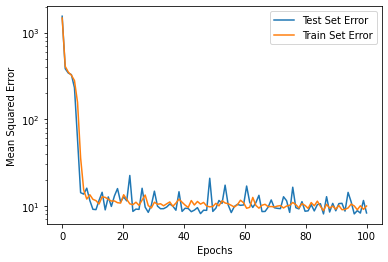

In [35]:
# Build and train HighPass model 
if __name__=='__main__': 
    PATH_TO_H5 = '/Users/aaronphilip/ScienceFair/projects/NanoporeSequencingFiltering/database/RefinedNanoporeFiltering.h5'
    ftype = 'HighPass'
    test_loader, train_loader = loaderSplit(PATH_TO_H5, ftype)
    
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]


    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")

    # 100 long input vector --> 2 long output vector 
    highModel = highNN().to(device)
    
    # Optimizer and Loss Function
    learning_rate = 1e-3
    optimizer = optim.Adam(highModel.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()

    # Training
    train_model(highModel, ftype=ftype, test_losses = test_losses, train_losses=train_losses)
    
    # Graph epochs vs. MSE
    graphTraining(test_losses, train_losses, test_loader)

Data Points in Training Set: 8000
Data Points in Test Set: 2000
Using cpu device

Test set: Avg. loss: 1607.7029

Train Epoch: 1 [0/8000 (0%)]	Loss: 1665.749634


<ipython-input-79-817ce5fa4d0f>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  powSpecArray[data] = (fhat * np.conj(fhat) / len(x[0]))[L]


Train Epoch: 1 [320/8000 (4%)]	Loss: 1451.748413
Train Epoch: 1 [640/8000 (8%)]	Loss: 1306.399658
Train Epoch: 1 [960/8000 (12%)]	Loss: 1126.208862
Train Epoch: 1 [1280/8000 (16%)]	Loss: 742.016357
Train Epoch: 1 [1600/8000 (20%)]	Loss: 494.071747
Train Epoch: 1 [1920/8000 (24%)]	Loss: 348.603790
Train Epoch: 1 [2240/8000 (28%)]	Loss: 223.495621
Train Epoch: 1 [2560/8000 (32%)]	Loss: 205.458130
Train Epoch: 1 [2880/8000 (36%)]	Loss: 185.345810
Train Epoch: 1 [3200/8000 (40%)]	Loss: 179.814590
Train Epoch: 1 [3520/8000 (44%)]	Loss: 183.826187
Train Epoch: 1 [3840/8000 (48%)]	Loss: 222.422134
Train Epoch: 1 [4160/8000 (52%)]	Loss: 159.724991
Train Epoch: 1 [4480/8000 (56%)]	Loss: 190.618164
Train Epoch: 1 [4800/8000 (60%)]	Loss: 187.554977
Train Epoch: 1 [5120/8000 (64%)]	Loss: 248.970047
Train Epoch: 1 [5440/8000 (68%)]	Loss: 210.350327
Train Epoch: 1 [5760/8000 (72%)]	Loss: 218.196121
Train Epoch: 1 [6080/8000 (76%)]	Loss: 195.365463
Train Epoch: 1 [6400/8000 (80%)]	Loss: 176.275681
Tr

Train Epoch: 7 [4480/8000 (56%)]	Loss: 7.606037
Train Epoch: 7 [4800/8000 (60%)]	Loss: 18.997005
Train Epoch: 7 [5120/8000 (64%)]	Loss: 3.191833
Train Epoch: 7 [5440/8000 (68%)]	Loss: 6.531781
Train Epoch: 7 [5760/8000 (72%)]	Loss: 5.670894
Train Epoch: 7 [6080/8000 (76%)]	Loss: 5.334991
Train Epoch: 7 [6400/8000 (80%)]	Loss: 5.640755
Train Epoch: 7 [6720/8000 (84%)]	Loss: 3.962216
Train Epoch: 7 [7040/8000 (88%)]	Loss: 4.210042
Train Epoch: 7 [7360/8000 (92%)]	Loss: 6.816977
Train Epoch: 7 [7680/8000 (96%)]	Loss: 3.406064

Test set: Avg. loss: 5.1874

Train Epoch: 8 [0/8000 (0%)]	Loss: 4.437481
Train Epoch: 8 [320/8000 (4%)]	Loss: 4.310771
Train Epoch: 8 [640/8000 (8%)]	Loss: 8.056232
Train Epoch: 8 [960/8000 (12%)]	Loss: 4.024929
Train Epoch: 8 [1280/8000 (16%)]	Loss: 51.840313
Train Epoch: 8 [1600/8000 (20%)]	Loss: 9.274997
Train Epoch: 8 [1920/8000 (24%)]	Loss: 5.260148
Train Epoch: 8 [2240/8000 (28%)]	Loss: 5.793485
Train Epoch: 8 [2560/8000 (32%)]	Loss: 6.024075
Train Epoch: 8 [2

Train Epoch: 14 [2240/8000 (28%)]	Loss: 2.397054
Train Epoch: 14 [2560/8000 (32%)]	Loss: 2.005779
Train Epoch: 14 [2880/8000 (36%)]	Loss: 3.016216
Train Epoch: 14 [3200/8000 (40%)]	Loss: 4.612641
Train Epoch: 14 [3520/8000 (44%)]	Loss: 2.647829
Train Epoch: 14 [3840/8000 (48%)]	Loss: 3.058017
Train Epoch: 14 [4160/8000 (52%)]	Loss: 5.599516
Train Epoch: 14 [4480/8000 (56%)]	Loss: 2.515177
Train Epoch: 14 [4800/8000 (60%)]	Loss: 2.770413
Train Epoch: 14 [5120/8000 (64%)]	Loss: 17.714228
Train Epoch: 14 [5440/8000 (68%)]	Loss: 7.091179
Train Epoch: 14 [5760/8000 (72%)]	Loss: 6.043798
Train Epoch: 14 [6080/8000 (76%)]	Loss: 5.883814
Train Epoch: 14 [6400/8000 (80%)]	Loss: 4.883628
Train Epoch: 14 [6720/8000 (84%)]	Loss: 3.163374
Train Epoch: 14 [7040/8000 (88%)]	Loss: 2.343755
Train Epoch: 14 [7360/8000 (92%)]	Loss: 4.423124
Train Epoch: 14 [7680/8000 (96%)]	Loss: 7.280182

Test set: Avg. loss: 4.7466

Train Epoch: 15 [0/8000 (0%)]	Loss: 3.599731
Train Epoch: 15 [320/8000 (4%)]	Loss: 6.40


Test set: Avg. loss: 4.3428

Train Epoch: 21 [0/8000 (0%)]	Loss: 4.244112
Train Epoch: 21 [320/8000 (4%)]	Loss: 6.530996
Train Epoch: 21 [640/8000 (8%)]	Loss: 4.572544
Train Epoch: 21 [960/8000 (12%)]	Loss: 3.672820
Train Epoch: 21 [1280/8000 (16%)]	Loss: 4.167142
Train Epoch: 21 [1600/8000 (20%)]	Loss: 1.908455
Train Epoch: 21 [1920/8000 (24%)]	Loss: 9.551975
Train Epoch: 21 [2240/8000 (28%)]	Loss: 3.617335
Train Epoch: 21 [2560/8000 (32%)]	Loss: 5.053417
Train Epoch: 21 [2880/8000 (36%)]	Loss: 6.772022
Train Epoch: 21 [3200/8000 (40%)]	Loss: 4.965321
Train Epoch: 21 [3520/8000 (44%)]	Loss: 3.396817
Train Epoch: 21 [3840/8000 (48%)]	Loss: 3.724275
Train Epoch: 21 [4160/8000 (52%)]	Loss: 2.491554
Train Epoch: 21 [4480/8000 (56%)]	Loss: 3.121754
Train Epoch: 21 [4800/8000 (60%)]	Loss: 3.809256
Train Epoch: 21 [5120/8000 (64%)]	Loss: 4.501610
Train Epoch: 21 [5440/8000 (68%)]	Loss: 5.240758
Train Epoch: 21 [5760/8000 (72%)]	Loss: 3.143961
Train Epoch: 21 [6080/8000 (76%)]	Loss: 4.365388

Train Epoch: 27 [6720/8000 (84%)]	Loss: 3.230195
Train Epoch: 27 [7040/8000 (88%)]	Loss: 2.556956
Train Epoch: 27 [7360/8000 (92%)]	Loss: 3.632977
Train Epoch: 27 [7680/8000 (96%)]	Loss: 6.634690

Test set: Avg. loss: 4.4177

Train Epoch: 28 [0/8000 (0%)]	Loss: 3.833423
Train Epoch: 28 [320/8000 (4%)]	Loss: 2.952112
Train Epoch: 28 [640/8000 (8%)]	Loss: 6.176222
Train Epoch: 28 [960/8000 (12%)]	Loss: 2.595331
Train Epoch: 28 [1280/8000 (16%)]	Loss: 3.423394
Train Epoch: 28 [1600/8000 (20%)]	Loss: 3.141411
Train Epoch: 28 [1920/8000 (24%)]	Loss: 5.342403
Train Epoch: 28 [2240/8000 (28%)]	Loss: 2.651478
Train Epoch: 28 [2560/8000 (32%)]	Loss: 2.580133
Train Epoch: 28 [2880/8000 (36%)]	Loss: 3.051286
Train Epoch: 28 [3200/8000 (40%)]	Loss: 3.965996
Train Epoch: 28 [3520/8000 (44%)]	Loss: 3.203430
Train Epoch: 28 [3840/8000 (48%)]	Loss: 3.160319
Train Epoch: 28 [4160/8000 (52%)]	Loss: 3.452062
Train Epoch: 28 [4480/8000 (56%)]	Loss: 2.487583
Train Epoch: 28 [4800/8000 (60%)]	Loss: 6.387296

Train Epoch: 34 [4480/8000 (56%)]	Loss: 2.372935
Train Epoch: 34 [4800/8000 (60%)]	Loss: 3.260321
Train Epoch: 34 [5120/8000 (64%)]	Loss: 3.601297
Train Epoch: 34 [5440/8000 (68%)]	Loss: 4.022569
Train Epoch: 34 [5760/8000 (72%)]	Loss: 4.195981
Train Epoch: 34 [6080/8000 (76%)]	Loss: 2.143209
Train Epoch: 34 [6400/8000 (80%)]	Loss: 2.356320
Train Epoch: 34 [6720/8000 (84%)]	Loss: 5.155989
Train Epoch: 34 [7040/8000 (88%)]	Loss: 4.893995
Train Epoch: 34 [7360/8000 (92%)]	Loss: 4.696939
Train Epoch: 34 [7680/8000 (96%)]	Loss: 3.850668

Test set: Avg. loss: 3.2452

Train Epoch: 35 [0/8000 (0%)]	Loss: 2.789779
Train Epoch: 35 [320/8000 (4%)]	Loss: 3.075422
Train Epoch: 35 [640/8000 (8%)]	Loss: 3.018831
Train Epoch: 35 [960/8000 (12%)]	Loss: 3.863861
Train Epoch: 35 [1280/8000 (16%)]	Loss: 8.586379
Train Epoch: 35 [1600/8000 (20%)]	Loss: 2.573589
Train Epoch: 35 [1920/8000 (24%)]	Loss: 2.160071
Train Epoch: 35 [2240/8000 (28%)]	Loss: 1.880237
Train Epoch: 35 [2560/8000 (32%)]	Loss: 2.254630

Train Epoch: 41 [2240/8000 (28%)]	Loss: 2.737685
Train Epoch: 41 [2560/8000 (32%)]	Loss: 4.035538
Train Epoch: 41 [2880/8000 (36%)]	Loss: 15.563770
Train Epoch: 41 [3200/8000 (40%)]	Loss: 2.919695
Train Epoch: 41 [3520/8000 (44%)]	Loss: 3.840520
Train Epoch: 41 [3840/8000 (48%)]	Loss: 2.786250
Train Epoch: 41 [4160/8000 (52%)]	Loss: 3.584862
Train Epoch: 41 [4480/8000 (56%)]	Loss: 2.593694
Train Epoch: 41 [4800/8000 (60%)]	Loss: 5.757533
Train Epoch: 41 [5120/8000 (64%)]	Loss: 2.836102
Train Epoch: 41 [5440/8000 (68%)]	Loss: 3.346387
Train Epoch: 41 [5760/8000 (72%)]	Loss: 3.528996
Train Epoch: 41 [6080/8000 (76%)]	Loss: 4.281555
Train Epoch: 41 [6400/8000 (80%)]	Loss: 3.419718
Train Epoch: 41 [6720/8000 (84%)]	Loss: 3.550100
Train Epoch: 41 [7040/8000 (88%)]	Loss: 11.890803
Train Epoch: 41 [7360/8000 (92%)]	Loss: 10.126924
Train Epoch: 41 [7680/8000 (96%)]	Loss: 5.123948

Test set: Avg. loss: 3.7794

Train Epoch: 42 [0/8000 (0%)]	Loss: 3.385475
Train Epoch: 42 [320/8000 (4%)]	Loss: 3.


Test set: Avg. loss: 4.0326

Train Epoch: 48 [0/8000 (0%)]	Loss: 4.208520
Train Epoch: 48 [320/8000 (4%)]	Loss: 5.090423
Train Epoch: 48 [640/8000 (8%)]	Loss: 4.846694
Train Epoch: 48 [960/8000 (12%)]	Loss: 3.149070
Train Epoch: 48 [1280/8000 (16%)]	Loss: 5.390142
Train Epoch: 48 [1600/8000 (20%)]	Loss: 4.574834
Train Epoch: 48 [1920/8000 (24%)]	Loss: 4.019296
Train Epoch: 48 [2240/8000 (28%)]	Loss: 3.034555
Train Epoch: 48 [2560/8000 (32%)]	Loss: 2.619521
Train Epoch: 48 [2880/8000 (36%)]	Loss: 2.505825
Train Epoch: 48 [3200/8000 (40%)]	Loss: 2.066231
Train Epoch: 48 [3520/8000 (44%)]	Loss: 3.241395
Train Epoch: 48 [3840/8000 (48%)]	Loss: 2.798072
Train Epoch: 48 [4160/8000 (52%)]	Loss: 2.956909
Train Epoch: 48 [4480/8000 (56%)]	Loss: 1.873304
Train Epoch: 48 [4800/8000 (60%)]	Loss: 2.369022
Train Epoch: 48 [5120/8000 (64%)]	Loss: 4.578947
Train Epoch: 48 [5440/8000 (68%)]	Loss: 4.422386
Train Epoch: 48 [5760/8000 (72%)]	Loss: 3.852933
Train Epoch: 48 [6080/8000 (76%)]	Loss: 3.902592

Train Epoch: 54 [6720/8000 (84%)]	Loss: 3.378550
Train Epoch: 54 [7040/8000 (88%)]	Loss: 3.612198
Train Epoch: 54 [7360/8000 (92%)]	Loss: 2.871768
Train Epoch: 54 [7680/8000 (96%)]	Loss: 3.218068

Test set: Avg. loss: 3.6806

Train Epoch: 55 [0/8000 (0%)]	Loss: 4.324274
Train Epoch: 55 [320/8000 (4%)]	Loss: 4.485098
Train Epoch: 55 [640/8000 (8%)]	Loss: 2.857697
Train Epoch: 55 [960/8000 (12%)]	Loss: 3.513270
Train Epoch: 55 [1280/8000 (16%)]	Loss: 3.475841
Train Epoch: 55 [1600/8000 (20%)]	Loss: 7.613799
Train Epoch: 55 [1920/8000 (24%)]	Loss: 4.832852
Train Epoch: 55 [2240/8000 (28%)]	Loss: 3.133990
Train Epoch: 55 [2560/8000 (32%)]	Loss: 6.893274
Train Epoch: 55 [2880/8000 (36%)]	Loss: 4.427184
Train Epoch: 55 [3200/8000 (40%)]	Loss: 2.759508
Train Epoch: 55 [3520/8000 (44%)]	Loss: 3.500911
Train Epoch: 55 [3840/8000 (48%)]	Loss: 3.502956
Train Epoch: 55 [4160/8000 (52%)]	Loss: 2.691767
Train Epoch: 55 [4480/8000 (56%)]	Loss: 1.625020
Train Epoch: 55 [4800/8000 (60%)]	Loss: 4.487951

Train Epoch: 61 [4480/8000 (56%)]	Loss: 3.196426
Train Epoch: 61 [4800/8000 (60%)]	Loss: 3.227601
Train Epoch: 61 [5120/8000 (64%)]	Loss: 3.865360
Train Epoch: 61 [5440/8000 (68%)]	Loss: 3.482593
Train Epoch: 61 [5760/8000 (72%)]	Loss: 2.585371
Train Epoch: 61 [6080/8000 (76%)]	Loss: 3.479790
Train Epoch: 61 [6400/8000 (80%)]	Loss: 2.314255
Train Epoch: 61 [6720/8000 (84%)]	Loss: 2.076871
Train Epoch: 61 [7040/8000 (88%)]	Loss: 4.037336
Train Epoch: 61 [7360/8000 (92%)]	Loss: 3.357115
Train Epoch: 61 [7680/8000 (96%)]	Loss: 2.236572

Test set: Avg. loss: 3.0105

Train Epoch: 62 [0/8000 (0%)]	Loss: 2.552546
Train Epoch: 62 [320/8000 (4%)]	Loss: 2.777999
Train Epoch: 62 [640/8000 (8%)]	Loss: 2.197402
Train Epoch: 62 [960/8000 (12%)]	Loss: 3.611636
Train Epoch: 62 [1280/8000 (16%)]	Loss: 3.768988
Train Epoch: 62 [1600/8000 (20%)]	Loss: 2.882865
Train Epoch: 62 [1920/8000 (24%)]	Loss: 3.098005
Train Epoch: 62 [2240/8000 (28%)]	Loss: 2.348798
Train Epoch: 62 [2560/8000 (32%)]	Loss: 3.731696

Train Epoch: 68 [2240/8000 (28%)]	Loss: 8.742245
Train Epoch: 68 [2560/8000 (32%)]	Loss: 3.450117
Train Epoch: 68 [2880/8000 (36%)]	Loss: 4.699104
Train Epoch: 68 [3200/8000 (40%)]	Loss: 3.235533
Train Epoch: 68 [3520/8000 (44%)]	Loss: 3.163423
Train Epoch: 68 [3840/8000 (48%)]	Loss: 6.112401
Train Epoch: 68 [4160/8000 (52%)]	Loss: 4.532722
Train Epoch: 68 [4480/8000 (56%)]	Loss: 4.742875
Train Epoch: 68 [4800/8000 (60%)]	Loss: 2.282844
Train Epoch: 68 [5120/8000 (64%)]	Loss: 4.453908
Train Epoch: 68 [5440/8000 (68%)]	Loss: 2.614643
Train Epoch: 68 [5760/8000 (72%)]	Loss: 2.471328
Train Epoch: 68 [6080/8000 (76%)]	Loss: 3.738132
Train Epoch: 68 [6400/8000 (80%)]	Loss: 3.149590
Train Epoch: 68 [6720/8000 (84%)]	Loss: 3.424760
Train Epoch: 68 [7040/8000 (88%)]	Loss: 3.406408
Train Epoch: 68 [7360/8000 (92%)]	Loss: 3.642130
Train Epoch: 68 [7680/8000 (96%)]	Loss: 2.909084

Test set: Avg. loss: 3.4969

Train Epoch: 69 [0/8000 (0%)]	Loss: 1.842606
Train Epoch: 69 [320/8000 (4%)]	Loss: 2.885


Test set: Avg. loss: 3.7809

Train Epoch: 75 [0/8000 (0%)]	Loss: 2.651628
Train Epoch: 75 [320/8000 (4%)]	Loss: 4.255386
Train Epoch: 75 [640/8000 (8%)]	Loss: 3.802706
Train Epoch: 75 [960/8000 (12%)]	Loss: 3.557170
Train Epoch: 75 [1280/8000 (16%)]	Loss: 3.542358
Train Epoch: 75 [1600/8000 (20%)]	Loss: 2.179186
Train Epoch: 75 [1920/8000 (24%)]	Loss: 3.297605
Train Epoch: 75 [2240/8000 (28%)]	Loss: 4.361852
Train Epoch: 75 [2560/8000 (32%)]	Loss: 3.317148
Train Epoch: 75 [2880/8000 (36%)]	Loss: 4.214483
Train Epoch: 75 [3200/8000 (40%)]	Loss: 4.262425
Train Epoch: 75 [3520/8000 (44%)]	Loss: 2.909942
Train Epoch: 75 [3840/8000 (48%)]	Loss: 3.764768
Train Epoch: 75 [4160/8000 (52%)]	Loss: 3.057595
Train Epoch: 75 [4480/8000 (56%)]	Loss: 3.019639
Train Epoch: 75 [4800/8000 (60%)]	Loss: 3.224921
Train Epoch: 75 [5120/8000 (64%)]	Loss: 3.209643
Train Epoch: 75 [5440/8000 (68%)]	Loss: 3.413994
Train Epoch: 75 [5760/8000 (72%)]	Loss: 4.091855
Train Epoch: 75 [6080/8000 (76%)]	Loss: 3.512932

Train Epoch: 81 [6720/8000 (84%)]	Loss: 4.676247
Train Epoch: 81 [7040/8000 (88%)]	Loss: 3.545727
Train Epoch: 81 [7360/8000 (92%)]	Loss: 3.278365
Train Epoch: 81 [7680/8000 (96%)]	Loss: 3.326751

Test set: Avg. loss: 3.0122

Train Epoch: 82 [0/8000 (0%)]	Loss: 2.108315
Train Epoch: 82 [320/8000 (4%)]	Loss: 2.447508
Train Epoch: 82 [640/8000 (8%)]	Loss: 4.024252
Train Epoch: 82 [960/8000 (12%)]	Loss: 1.855625
Train Epoch: 82 [1280/8000 (16%)]	Loss: 3.441617
Train Epoch: 82 [1600/8000 (20%)]	Loss: 2.948336
Train Epoch: 82 [1920/8000 (24%)]	Loss: 3.622113
Train Epoch: 82 [2240/8000 (28%)]	Loss: 2.930897
Train Epoch: 82 [2560/8000 (32%)]	Loss: 3.289876
Train Epoch: 82 [2880/8000 (36%)]	Loss: 5.690212
Train Epoch: 82 [3200/8000 (40%)]	Loss: 7.332788
Train Epoch: 82 [3520/8000 (44%)]	Loss: 2.624278
Train Epoch: 82 [3840/8000 (48%)]	Loss: 2.666882
Train Epoch: 82 [4160/8000 (52%)]	Loss: 3.558221
Train Epoch: 82 [4480/8000 (56%)]	Loss: 6.329401
Train Epoch: 82 [4800/8000 (60%)]	Loss: 6.428987

Train Epoch: 88 [4480/8000 (56%)]	Loss: 5.317479
Train Epoch: 88 [4800/8000 (60%)]	Loss: 4.632251
Train Epoch: 88 [5120/8000 (64%)]	Loss: 5.469015
Train Epoch: 88 [5440/8000 (68%)]	Loss: 6.237316
Train Epoch: 88 [5760/8000 (72%)]	Loss: 3.067245
Train Epoch: 88 [6080/8000 (76%)]	Loss: 2.322664
Train Epoch: 88 [6400/8000 (80%)]	Loss: 3.625540
Train Epoch: 88 [6720/8000 (84%)]	Loss: 2.853519
Train Epoch: 88 [7040/8000 (88%)]	Loss: 2.334908
Train Epoch: 88 [7360/8000 (92%)]	Loss: 2.503912
Train Epoch: 88 [7680/8000 (96%)]	Loss: 1.946952

Test set: Avg. loss: 3.5147

Train Epoch: 89 [0/8000 (0%)]	Loss: 1.740439
Train Epoch: 89 [320/8000 (4%)]	Loss: 4.520663
Train Epoch: 89 [640/8000 (8%)]	Loss: 4.297533
Train Epoch: 89 [960/8000 (12%)]	Loss: 4.370021
Train Epoch: 89 [1280/8000 (16%)]	Loss: 2.874888
Train Epoch: 89 [1600/8000 (20%)]	Loss: 3.575024
Train Epoch: 89 [1920/8000 (24%)]	Loss: 3.299934
Train Epoch: 89 [2240/8000 (28%)]	Loss: 4.613186
Train Epoch: 89 [2560/8000 (32%)]	Loss: 3.396609

Train Epoch: 95 [2240/8000 (28%)]	Loss: 3.491613
Train Epoch: 95 [2560/8000 (32%)]	Loss: 48.933853
Train Epoch: 95 [2880/8000 (36%)]	Loss: 2.888885
Train Epoch: 95 [3200/8000 (40%)]	Loss: 3.379565
Train Epoch: 95 [3520/8000 (44%)]	Loss: 2.376342
Train Epoch: 95 [3840/8000 (48%)]	Loss: 3.651236
Train Epoch: 95 [4160/8000 (52%)]	Loss: 2.723658
Train Epoch: 95 [4480/8000 (56%)]	Loss: 2.872123
Train Epoch: 95 [4800/8000 (60%)]	Loss: 3.998626
Train Epoch: 95 [5120/8000 (64%)]	Loss: 2.280975
Train Epoch: 95 [5440/8000 (68%)]	Loss: 4.008286
Train Epoch: 95 [5760/8000 (72%)]	Loss: 6.907300
Train Epoch: 95 [6080/8000 (76%)]	Loss: 2.778897
Train Epoch: 95 [6400/8000 (80%)]	Loss: 4.776868
Train Epoch: 95 [6720/8000 (84%)]	Loss: 4.994668
Train Epoch: 95 [7040/8000 (88%)]	Loss: 3.497673
Train Epoch: 95 [7360/8000 (92%)]	Loss: 3.242601
Train Epoch: 95 [7680/8000 (96%)]	Loss: 4.662889

Test set: Avg. loss: 3.3278

Train Epoch: 96 [0/8000 (0%)]	Loss: 2.706683
Train Epoch: 96 [320/8000 (4%)]	Loss: 3.69

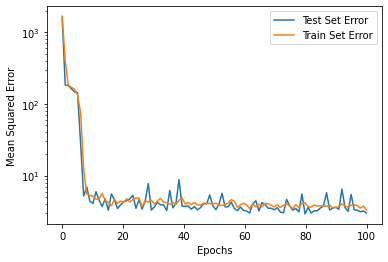

In [83]:
# Build and train BandPass model 
if __name__=='__main__': 
    PATH_TO_H5 = '/Users/aaronphilip/ScienceFair/projects/NanoporeSequencingFiltering/database/RefinedNanoporeFiltering.h5'
    ftype = 'BandPass'
    test_loader, train_loader = loaderSplit(PATH_TO_H5, ftype)
    
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]


    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")

    # 100 long input vector --> 2 long output vector 
    bandModel = bandNN().to(device)
    
    # Optimizer and Loss Function
    learning_rate = 1e-3
    optimizer = optim.Adam(bandModel.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()

    # Training
    train_model(bandModel, ftype=ftype, test_losses=test_losses, train_losses=train_losses)
    graphTraining(test_losses, train_losses, test_loader)

Data Points in Training Set: 8000
Data Points in Test Set: 2000
Using cpu device

Test set: Avg. loss: 2922.6609

Train Epoch: 1 [0/8000 (0%)]	Loss: 2811.879639
Train Epoch: 1 [320/8000 (4%)]	Loss: 392.987213
Train Epoch: 1 [640/8000 (8%)]	Loss: 25.589621
Train Epoch: 1 [960/8000 (12%)]	Loss: 18.505163
Train Epoch: 1 [1280/8000 (16%)]	Loss: 16.008860
Train Epoch: 1 [1600/8000 (20%)]	Loss: 21.304750
Train Epoch: 1 [1920/8000 (24%)]	Loss: 19.759758


<ipython-input-38-5c95e66c9f46>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  powSpecArray[data] = (fhat * np.conj(fhat) / len(x[0]))[L]


Train Epoch: 1 [2240/8000 (28%)]	Loss: 17.912092
Train Epoch: 1 [2560/8000 (32%)]	Loss: 22.326656
Train Epoch: 1 [2880/8000 (36%)]	Loss: 15.625724
Train Epoch: 1 [3200/8000 (40%)]	Loss: 14.759875
Train Epoch: 1 [3520/8000 (44%)]	Loss: 16.899872
Train Epoch: 1 [3840/8000 (48%)]	Loss: 21.562750
Train Epoch: 1 [4160/8000 (52%)]	Loss: 16.535770
Train Epoch: 1 [4480/8000 (56%)]	Loss: 16.713461
Train Epoch: 1 [4800/8000 (60%)]	Loss: 12.503753
Train Epoch: 1 [5120/8000 (64%)]	Loss: 17.071012
Train Epoch: 1 [5440/8000 (68%)]	Loss: 17.347326
Train Epoch: 1 [5760/8000 (72%)]	Loss: 11.809443
Train Epoch: 1 [6080/8000 (76%)]	Loss: 13.718389
Train Epoch: 1 [6400/8000 (80%)]	Loss: 11.435276
Train Epoch: 1 [6720/8000 (84%)]	Loss: 11.702542
Train Epoch: 1 [7040/8000 (88%)]	Loss: 16.121624
Train Epoch: 1 [7360/8000 (92%)]	Loss: 10.786800
Train Epoch: 1 [7680/8000 (96%)]	Loss: 11.318946

Test set: Avg. loss: 12.3109

Train Epoch: 2 [0/8000 (0%)]	Loss: 9.377959
Train Epoch: 2 [320/8000 (4%)]	Loss: 12.352


Test set: Avg. loss: 5.6975

Train Epoch: 8 [0/8000 (0%)]	Loss: 5.775000
Train Epoch: 8 [320/8000 (4%)]	Loss: 5.640321
Train Epoch: 8 [640/8000 (8%)]	Loss: 5.652793
Train Epoch: 8 [960/8000 (12%)]	Loss: 5.331578
Train Epoch: 8 [1280/8000 (16%)]	Loss: 6.173776
Train Epoch: 8 [1600/8000 (20%)]	Loss: 6.081171
Train Epoch: 8 [1920/8000 (24%)]	Loss: 5.952784
Train Epoch: 8 [2240/8000 (28%)]	Loss: 5.581268
Train Epoch: 8 [2560/8000 (32%)]	Loss: 6.376666
Train Epoch: 8 [2880/8000 (36%)]	Loss: 6.384166
Train Epoch: 8 [3200/8000 (40%)]	Loss: 5.368817
Train Epoch: 8 [3520/8000 (44%)]	Loss: 6.234175
Train Epoch: 8 [3840/8000 (48%)]	Loss: 6.090890
Train Epoch: 8 [4160/8000 (52%)]	Loss: 5.660657
Train Epoch: 8 [4480/8000 (56%)]	Loss: 5.255763
Train Epoch: 8 [4800/8000 (60%)]	Loss: 5.051901
Train Epoch: 8 [5120/8000 (64%)]	Loss: 5.874403
Train Epoch: 8 [5440/8000 (68%)]	Loss: 5.182369
Train Epoch: 8 [5760/8000 (72%)]	Loss: 6.118908
Train Epoch: 8 [6080/8000 (76%)]	Loss: 4.453586
Train Epoch: 8 [640


Test set: Avg. loss: 5.6955

Train Epoch: 15 [0/8000 (0%)]	Loss: 5.952912
Train Epoch: 15 [320/8000 (4%)]	Loss: 5.277554
Train Epoch: 15 [640/8000 (8%)]	Loss: 5.706876
Train Epoch: 15 [960/8000 (12%)]	Loss: 6.317850
Train Epoch: 15 [1280/8000 (16%)]	Loss: 7.145653
Train Epoch: 15 [1600/8000 (20%)]	Loss: 6.064547
Train Epoch: 15 [1920/8000 (24%)]	Loss: 6.060893
Train Epoch: 15 [2240/8000 (28%)]	Loss: 5.328449
Train Epoch: 15 [2560/8000 (32%)]	Loss: 5.633116
Train Epoch: 15 [2880/8000 (36%)]	Loss: 5.678754
Train Epoch: 15 [3200/8000 (40%)]	Loss: 5.630015
Train Epoch: 15 [3520/8000 (44%)]	Loss: 5.668685
Train Epoch: 15 [3840/8000 (48%)]	Loss: 5.666741
Train Epoch: 15 [4160/8000 (52%)]	Loss: 5.129107
Train Epoch: 15 [4480/8000 (56%)]	Loss: 5.828670
Train Epoch: 15 [4800/8000 (60%)]	Loss: 6.122031
Train Epoch: 15 [5120/8000 (64%)]	Loss: 6.315818
Train Epoch: 15 [5440/8000 (68%)]	Loss: 6.166008
Train Epoch: 15 [5760/8000 (72%)]	Loss: 5.853831
Train Epoch: 15 [6080/8000 (76%)]	Loss: 5.094361


Test set: Avg. loss: 5.7039

Train Epoch: 22 [0/8000 (0%)]	Loss: 5.319416
Train Epoch: 22 [320/8000 (4%)]	Loss: 5.318817
Train Epoch: 22 [640/8000 (8%)]	Loss: 5.622148
Train Epoch: 22 [960/8000 (12%)]	Loss: 5.869520
Train Epoch: 22 [1280/8000 (16%)]	Loss: 6.065608
Train Epoch: 22 [1600/8000 (20%)]	Loss: 5.242057
Train Epoch: 22 [1920/8000 (24%)]	Loss: 5.989962
Train Epoch: 22 [2240/8000 (28%)]	Loss: 5.140579
Train Epoch: 22 [2560/8000 (32%)]	Loss: 6.903530
Train Epoch: 22 [2880/8000 (36%)]	Loss: 5.052295
Train Epoch: 22 [3200/8000 (40%)]	Loss: 6.801760
Train Epoch: 22 [3520/8000 (44%)]	Loss: 6.511500
Train Epoch: 22 [3840/8000 (48%)]	Loss: 5.632699
Train Epoch: 22 [4160/8000 (52%)]	Loss: 6.323326
Train Epoch: 22 [4480/8000 (56%)]	Loss: 6.741289
Train Epoch: 22 [4800/8000 (60%)]	Loss: 4.803880
Train Epoch: 22 [5120/8000 (64%)]	Loss: 7.183464
Train Epoch: 22 [5440/8000 (68%)]	Loss: 5.499825
Train Epoch: 22 [5760/8000 (72%)]	Loss: 5.920670
Train Epoch: 22 [6080/8000 (76%)]	Loss: 6.573558


Test set: Avg. loss: 5.6959

Train Epoch: 29 [0/8000 (0%)]	Loss: 4.572618
Train Epoch: 29 [320/8000 (4%)]	Loss: 6.723870
Train Epoch: 29 [640/8000 (8%)]	Loss: 4.578592
Train Epoch: 29 [960/8000 (12%)]	Loss: 5.424687
Train Epoch: 29 [1280/8000 (16%)]	Loss: 6.976225
Train Epoch: 29 [1600/8000 (20%)]	Loss: 4.418323
Train Epoch: 29 [1920/8000 (24%)]	Loss: 5.781083
Train Epoch: 29 [2240/8000 (28%)]	Loss: 7.587077
Train Epoch: 29 [2560/8000 (32%)]	Loss: 5.536315
Train Epoch: 29 [2880/8000 (36%)]	Loss: 6.266340
Train Epoch: 29 [3200/8000 (40%)]	Loss: 5.620309
Train Epoch: 29 [3520/8000 (44%)]	Loss: 5.981659
Train Epoch: 29 [3840/8000 (48%)]	Loss: 5.670544
Train Epoch: 29 [4160/8000 (52%)]	Loss: 6.467870
Train Epoch: 29 [4480/8000 (56%)]	Loss: 6.660664
Train Epoch: 29 [4800/8000 (60%)]	Loss: 5.560957
Train Epoch: 29 [5120/8000 (64%)]	Loss: 6.594082
Train Epoch: 29 [5440/8000 (68%)]	Loss: 6.500254
Train Epoch: 29 [5760/8000 (72%)]	Loss: 5.578412
Train Epoch: 29 [6080/8000 (76%)]	Loss: 6.198964


Test set: Avg. loss: 5.7025

Train Epoch: 36 [0/8000 (0%)]	Loss: 6.075628
Train Epoch: 36 [320/8000 (4%)]	Loss: 6.737105
Train Epoch: 36 [640/8000 (8%)]	Loss: 6.340316
Train Epoch: 36 [960/8000 (12%)]	Loss: 5.895578
Train Epoch: 36 [1280/8000 (16%)]	Loss: 5.480188
Train Epoch: 36 [1600/8000 (20%)]	Loss: 5.682759
Train Epoch: 36 [1920/8000 (24%)]	Loss: 7.151443
Train Epoch: 36 [2240/8000 (28%)]	Loss: 4.747853
Train Epoch: 36 [2560/8000 (32%)]	Loss: 5.053389
Train Epoch: 36 [2880/8000 (36%)]	Loss: 6.207035
Train Epoch: 36 [3200/8000 (40%)]	Loss: 5.484394
Train Epoch: 36 [3520/8000 (44%)]	Loss: 6.616968
Train Epoch: 36 [3840/8000 (48%)]	Loss: 6.399365
Train Epoch: 36 [4160/8000 (52%)]	Loss: 5.629565
Train Epoch: 36 [4480/8000 (56%)]	Loss: 6.124481
Train Epoch: 36 [4800/8000 (60%)]	Loss: 6.588701
Train Epoch: 36 [5120/8000 (64%)]	Loss: 6.376065
Train Epoch: 36 [5440/8000 (68%)]	Loss: 5.728180
Train Epoch: 36 [5760/8000 (72%)]	Loss: 4.963583
Train Epoch: 36 [6080/8000 (76%)]	Loss: 5.599602


Test set: Avg. loss: 5.7040

Train Epoch: 43 [0/8000 (0%)]	Loss: 5.855853
Train Epoch: 43 [320/8000 (4%)]	Loss: 6.288630
Train Epoch: 43 [640/8000 (8%)]	Loss: 6.124712
Train Epoch: 43 [960/8000 (12%)]	Loss: 6.128914
Train Epoch: 43 [1280/8000 (16%)]	Loss: 6.009777
Train Epoch: 43 [1600/8000 (20%)]	Loss: 5.934927
Train Epoch: 43 [1920/8000 (24%)]	Loss: 5.552944
Train Epoch: 43 [2240/8000 (28%)]	Loss: 5.035217
Train Epoch: 43 [2560/8000 (32%)]	Loss: 5.885268
Train Epoch: 43 [2880/8000 (36%)]	Loss: 6.561955
Train Epoch: 43 [3200/8000 (40%)]	Loss: 5.795284
Train Epoch: 43 [3520/8000 (44%)]	Loss: 5.835298
Train Epoch: 43 [3840/8000 (48%)]	Loss: 5.843485
Train Epoch: 43 [4160/8000 (52%)]	Loss: 6.738952
Train Epoch: 43 [4480/8000 (56%)]	Loss: 6.128466
Train Epoch: 43 [4800/8000 (60%)]	Loss: 6.014940
Train Epoch: 43 [5120/8000 (64%)]	Loss: 6.384967
Train Epoch: 43 [5440/8000 (68%)]	Loss: 5.534859
Train Epoch: 43 [5760/8000 (72%)]	Loss: 6.068572
Train Epoch: 43 [6080/8000 (76%)]	Loss: 5.803778


Test set: Avg. loss: 5.7046

Train Epoch: 50 [0/8000 (0%)]	Loss: 6.167613
Train Epoch: 50 [320/8000 (4%)]	Loss: 6.243257
Train Epoch: 50 [640/8000 (8%)]	Loss: 5.903275
Train Epoch: 50 [960/8000 (12%)]	Loss: 5.226768
Train Epoch: 50 [1280/8000 (16%)]	Loss: 5.313563
Train Epoch: 50 [1600/8000 (20%)]	Loss: 6.322645
Train Epoch: 50 [1920/8000 (24%)]	Loss: 5.082421
Train Epoch: 50 [2240/8000 (28%)]	Loss: 5.746479
Train Epoch: 50 [2560/8000 (32%)]	Loss: 5.523661
Train Epoch: 50 [2880/8000 (36%)]	Loss: 6.039067
Train Epoch: 50 [3200/8000 (40%)]	Loss: 5.812655
Train Epoch: 50 [3520/8000 (44%)]	Loss: 4.784650
Train Epoch: 50 [3840/8000 (48%)]	Loss: 7.054492
Train Epoch: 50 [4160/8000 (52%)]	Loss: 4.814692
Train Epoch: 50 [4480/8000 (56%)]	Loss: 5.915751
Train Epoch: 50 [4800/8000 (60%)]	Loss: 5.902014
Train Epoch: 50 [5120/8000 (64%)]	Loss: 5.543830
Train Epoch: 50 [5440/8000 (68%)]	Loss: 5.709289
Train Epoch: 50 [5760/8000 (72%)]	Loss: 5.351632
Train Epoch: 50 [6080/8000 (76%)]	Loss: 7.554261


Test set: Avg. loss: 5.6981

Train Epoch: 57 [0/8000 (0%)]	Loss: 5.205901
Train Epoch: 57 [320/8000 (4%)]	Loss: 6.086745
Train Epoch: 57 [640/8000 (8%)]	Loss: 5.754756
Train Epoch: 57 [960/8000 (12%)]	Loss: 5.951417
Train Epoch: 57 [1280/8000 (16%)]	Loss: 5.695433
Train Epoch: 57 [1600/8000 (20%)]	Loss: 5.654359
Train Epoch: 57 [1920/8000 (24%)]	Loss: 5.283082
Train Epoch: 57 [2240/8000 (28%)]	Loss: 6.140812
Train Epoch: 57 [2560/8000 (32%)]	Loss: 6.883175
Train Epoch: 57 [2880/8000 (36%)]	Loss: 5.081956
Train Epoch: 57 [3200/8000 (40%)]	Loss: 6.931551
Train Epoch: 57 [3520/8000 (44%)]	Loss: 5.569785
Train Epoch: 57 [3840/8000 (48%)]	Loss: 5.778215
Train Epoch: 57 [4160/8000 (52%)]	Loss: 5.353800
Train Epoch: 57 [4480/8000 (56%)]	Loss: 6.265077
Train Epoch: 57 [4800/8000 (60%)]	Loss: 5.315351
Train Epoch: 57 [5120/8000 (64%)]	Loss: 6.860486
Train Epoch: 57 [5440/8000 (68%)]	Loss: 6.861148
Train Epoch: 57 [5760/8000 (72%)]	Loss: 6.598068
Train Epoch: 57 [6080/8000 (76%)]	Loss: 5.683442


Test set: Avg. loss: 5.6973

Train Epoch: 64 [0/8000 (0%)]	Loss: 6.241515
Train Epoch: 64 [320/8000 (4%)]	Loss: 5.743206
Train Epoch: 64 [640/8000 (8%)]	Loss: 4.584980
Train Epoch: 64 [960/8000 (12%)]	Loss: 6.756064
Train Epoch: 64 [1280/8000 (16%)]	Loss: 6.262698
Train Epoch: 64 [1600/8000 (20%)]	Loss: 5.897393
Train Epoch: 64 [1920/8000 (24%)]	Loss: 5.495616
Train Epoch: 64 [2240/8000 (28%)]	Loss: 6.352760
Train Epoch: 64 [2560/8000 (32%)]	Loss: 5.811902
Train Epoch: 64 [2880/8000 (36%)]	Loss: 5.929501
Train Epoch: 64 [3200/8000 (40%)]	Loss: 5.866006
Train Epoch: 64 [3520/8000 (44%)]	Loss: 6.474632
Train Epoch: 64 [3840/8000 (48%)]	Loss: 6.273498
Train Epoch: 64 [4160/8000 (52%)]	Loss: 5.402093
Train Epoch: 64 [4480/8000 (56%)]	Loss: 5.804904
Train Epoch: 64 [4800/8000 (60%)]	Loss: 4.682736
Train Epoch: 64 [5120/8000 (64%)]	Loss: 5.707076
Train Epoch: 64 [5440/8000 (68%)]	Loss: 5.513071
Train Epoch: 64 [5760/8000 (72%)]	Loss: 5.378236
Train Epoch: 64 [6080/8000 (76%)]	Loss: 6.452753


Test set: Avg. loss: 5.7091

Train Epoch: 71 [0/8000 (0%)]	Loss: 5.289355
Train Epoch: 71 [320/8000 (4%)]	Loss: 4.408143
Train Epoch: 71 [640/8000 (8%)]	Loss: 6.187901
Train Epoch: 71 [960/8000 (12%)]	Loss: 5.452941
Train Epoch: 71 [1280/8000 (16%)]	Loss: 6.434558
Train Epoch: 71 [1600/8000 (20%)]	Loss: 5.930583
Train Epoch: 71 [1920/8000 (24%)]	Loss: 5.664835
Train Epoch: 71 [2240/8000 (28%)]	Loss: 6.277091
Train Epoch: 71 [2560/8000 (32%)]	Loss: 6.634695
Train Epoch: 71 [2880/8000 (36%)]	Loss: 6.241497
Train Epoch: 71 [3200/8000 (40%)]	Loss: 5.331790
Train Epoch: 71 [3520/8000 (44%)]	Loss: 6.632791
Train Epoch: 71 [3840/8000 (48%)]	Loss: 5.728732
Train Epoch: 71 [4160/8000 (52%)]	Loss: 5.838527
Train Epoch: 71 [4480/8000 (56%)]	Loss: 6.364521
Train Epoch: 71 [4800/8000 (60%)]	Loss: 6.032696
Train Epoch: 71 [5120/8000 (64%)]	Loss: 5.206833
Train Epoch: 71 [5440/8000 (68%)]	Loss: 6.261331
Train Epoch: 71 [5760/8000 (72%)]	Loss: 6.098128
Train Epoch: 71 [6080/8000 (76%)]	Loss: 6.501498


Test set: Avg. loss: 5.6986

Train Epoch: 78 [0/8000 (0%)]	Loss: 6.136909
Train Epoch: 78 [320/8000 (4%)]	Loss: 5.919961
Train Epoch: 78 [640/8000 (8%)]	Loss: 6.449677
Train Epoch: 78 [960/8000 (12%)]	Loss: 6.244457
Train Epoch: 78 [1280/8000 (16%)]	Loss: 5.775166
Train Epoch: 78 [1600/8000 (20%)]	Loss: 4.859578
Train Epoch: 78 [1920/8000 (24%)]	Loss: 6.119798
Train Epoch: 78 [2240/8000 (28%)]	Loss: 5.610111
Train Epoch: 78 [2560/8000 (32%)]	Loss: 5.380497
Train Epoch: 78 [2880/8000 (36%)]	Loss: 6.012365
Train Epoch: 78 [3200/8000 (40%)]	Loss: 5.940699
Train Epoch: 78 [3520/8000 (44%)]	Loss: 6.139180
Train Epoch: 78 [3840/8000 (48%)]	Loss: 7.281832
Train Epoch: 78 [4160/8000 (52%)]	Loss: 5.606777
Train Epoch: 78 [4480/8000 (56%)]	Loss: 5.425421
Train Epoch: 78 [4800/8000 (60%)]	Loss: 5.707570
Train Epoch: 78 [5120/8000 (64%)]	Loss: 5.848752
Train Epoch: 78 [5440/8000 (68%)]	Loss: 4.912765
Train Epoch: 78 [5760/8000 (72%)]	Loss: 6.638481
Train Epoch: 78 [6080/8000 (76%)]	Loss: 6.203376


Test set: Avg. loss: 5.7004

Train Epoch: 85 [0/8000 (0%)]	Loss: 6.528717
Train Epoch: 85 [320/8000 (4%)]	Loss: 6.900027
Train Epoch: 85 [640/8000 (8%)]	Loss: 4.970940
Train Epoch: 85 [960/8000 (12%)]	Loss: 5.886165
Train Epoch: 85 [1280/8000 (16%)]	Loss: 5.770361
Train Epoch: 85 [1600/8000 (20%)]	Loss: 5.885302
Train Epoch: 85 [1920/8000 (24%)]	Loss: 6.193227
Train Epoch: 85 [2240/8000 (28%)]	Loss: 5.838641
Train Epoch: 85 [2560/8000 (32%)]	Loss: 6.112488
Train Epoch: 85 [2880/8000 (36%)]	Loss: 5.118859
Train Epoch: 85 [3200/8000 (40%)]	Loss: 6.705523
Train Epoch: 85 [3520/8000 (44%)]	Loss: 6.179629
Train Epoch: 85 [3840/8000 (48%)]	Loss: 6.365482
Train Epoch: 85 [4160/8000 (52%)]	Loss: 6.008749
Train Epoch: 85 [4480/8000 (56%)]	Loss: 5.827072
Train Epoch: 85 [4800/8000 (60%)]	Loss: 6.488298
Train Epoch: 85 [5120/8000 (64%)]	Loss: 7.431129
Train Epoch: 85 [5440/8000 (68%)]	Loss: 5.644200
Train Epoch: 85 [5760/8000 (72%)]	Loss: 6.246126
Train Epoch: 85 [6080/8000 (76%)]	Loss: 6.015185


Test set: Avg. loss: 5.6959

Train Epoch: 92 [0/8000 (0%)]	Loss: 6.031645
Train Epoch: 92 [320/8000 (4%)]	Loss: 5.131490
Train Epoch: 92 [640/8000 (8%)]	Loss: 5.865716
Train Epoch: 92 [960/8000 (12%)]	Loss: 5.677354
Train Epoch: 92 [1280/8000 (16%)]	Loss: 6.392792
Train Epoch: 92 [1600/8000 (20%)]	Loss: 6.425937
Train Epoch: 92 [1920/8000 (24%)]	Loss: 5.840663
Train Epoch: 92 [2240/8000 (28%)]	Loss: 5.728748
Train Epoch: 92 [2560/8000 (32%)]	Loss: 5.077675
Train Epoch: 92 [2880/8000 (36%)]	Loss: 6.213603
Train Epoch: 92 [3200/8000 (40%)]	Loss: 5.358068
Train Epoch: 92 [3520/8000 (44%)]	Loss: 6.348896
Train Epoch: 92 [3840/8000 (48%)]	Loss: 5.246438
Train Epoch: 92 [4160/8000 (52%)]	Loss: 5.471455
Train Epoch: 92 [4480/8000 (56%)]	Loss: 5.955670
Train Epoch: 92 [4800/8000 (60%)]	Loss: 5.227815
Train Epoch: 92 [5120/8000 (64%)]	Loss: 5.862813
Train Epoch: 92 [5440/8000 (68%)]	Loss: 5.293694
Train Epoch: 92 [5760/8000 (72%)]	Loss: 5.818659
Train Epoch: 92 [6080/8000 (76%)]	Loss: 5.268691


Test set: Avg. loss: 5.6986

Train Epoch: 99 [0/8000 (0%)]	Loss: 7.307856
Train Epoch: 99 [320/8000 (4%)]	Loss: 5.765446
Train Epoch: 99 [640/8000 (8%)]	Loss: 5.035089
Train Epoch: 99 [960/8000 (12%)]	Loss: 6.204134
Train Epoch: 99 [1280/8000 (16%)]	Loss: 5.395159
Train Epoch: 99 [1600/8000 (20%)]	Loss: 5.398693
Train Epoch: 99 [1920/8000 (24%)]	Loss: 6.131290
Train Epoch: 99 [2240/8000 (28%)]	Loss: 6.241012
Train Epoch: 99 [2560/8000 (32%)]	Loss: 6.411123
Train Epoch: 99 [2880/8000 (36%)]	Loss: 5.581823
Train Epoch: 99 [3200/8000 (40%)]	Loss: 6.216004
Train Epoch: 99 [3520/8000 (44%)]	Loss: 5.200574
Train Epoch: 99 [3840/8000 (48%)]	Loss: 5.959816
Train Epoch: 99 [4160/8000 (52%)]	Loss: 6.148397
Train Epoch: 99 [4480/8000 (56%)]	Loss: 4.981616
Train Epoch: 99 [4800/8000 (60%)]	Loss: 5.903281
Train Epoch: 99 [5120/8000 (64%)]	Loss: 5.402467
Train Epoch: 99 [5440/8000 (68%)]	Loss: 5.087573
Train Epoch: 99 [5760/8000 (72%)]	Loss: 5.763564
Train Epoch: 99 [6080/8000 (76%)]	Loss: 5.938597

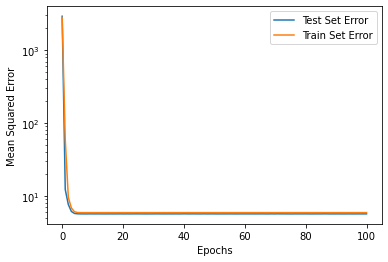

In [42]:
# Build and train BandPass model 
if __name__=='__main__': 
    PATH_TO_H5 = '/Users/aaronphilip/ScienceFair/projects/NanoporeSequencingFiltering/database/RefinedNanoporeFiltering.h5'
    ftype = 'ButterworthLowPass'
    test_loader, train_loader = loaderSplit(PATH_TO_H5, ftype)
    
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]


    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")

    # 100 long input vector --> 3 long output vector 
    butterModel = butterlowNN().to(device)
    
    # Optimizer and Loss Function
    learning_rate = 1e-2
    optimizer = optim.Adam(butterModel.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()

    # Training
    train_model(butterModel, ftype=ftype, test_losses=test_losses, train_losses=train_losses)
    graphTraining(test_losses, train_losses, test_loader)